In [1]:
import pandas as pd
import os 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.pipeline import Pipeline
from sklearn import preprocessing, model_selection, base, linear_model
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA

import datetime as dt

np.seterr(divide='ignore', invalid='ignore')

%matplotlib inline 
os.getcwd()

/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


'/Users/chadleonard/Springboard/work/springboard/capstone/projects/capstone1_Sberbank'

In [2]:
def fix_num_cols(dframe, skiplist):
    for col in dframe.columns.values:
        if col not in skiplist:
            if not isinstance(dframe[col].dtype,(str)):
                try:
                    #dframe[col].fillna(dframe[col].mean(), inplace=True)
                    dframe[col].fillna(dframe[col].median(), inplace=True)
                except:
                    print('error: ' + col)
                    #dframe.drop(col, inplace=True, axis=1)
    return dframe

def get_cor(dframe, skiplist):
    flist = []
    for col in dframe.columns.values:
        if col not in skiplist:
            if not isinstance(dframe[col].dtype,(str)):
                try:
                    cor = np.corrcoef(dframe['price_cat'], dframe[col])
                    #if np.abs(cor[1][0]) >= .2:
                    if np.abs(cor[1][0]) >= .001:
                        flist.append(((np.abs(cor[1][0]),cor[1][0]),col))
                except:
                    print('error: ' + col)            

    return sorted(flist,reverse=True)

In [3]:
if __name__ == "__main__":
    print (dt.datetime.now())
    dir_path = os.getcwd() + '/../../../data/all/'
    print (dir_path)
    df = pd.read_csv(dir_path + 'train.csv')
    df_macro = pd.read_csv(dir_path + 'macro.csv')

    df_macro['old_education_build_share_ind'] = df_macro['old_education_build_share'].astype('category').cat.codes
    df_macro['modern_education_share_ind'] = df_macro['modern_education_share'].astype('category').cat.codes

    df_macro = df_macro.drop(['modern_education_share','old_education_build_share'], axis=1)

    df['price_cat'] = pd.Series([7.5 if cat > 5e6 and cat < 1e7 else len(str(cat)) \
                                 for cat in df['price_doc'] ]).astype('category').cat.codes
    
    df.loc[df.price_cat == 4, 'price_cat'] = 3
    df_eda = pd.merge(df, df_macro, how='inner', on='timestamp', left_on=None, right_on=None,
         left_index=False, right_index=False, sort=True,
         suffixes=('_x', '_y'), copy=True, indicator=False,
         validate=None)

    print(len(df_eda.columns.values))
    
    

2018-11-02 08:47:20.335066
/Users/chadleonard/Springboard/work/springboard/capstone/projects/capstone1_Sberbank/../../../data/all/
392


In [19]:
#print(df_macro.columns.values)

df_1 = df[['timestamp','price_cat','price_doc']]

df_1 = pd.merge(df_1, df_macro, how='inner', on='timestamp', left_on=None, right_on=None,
         left_index=False, right_index=False, sort=True,
         suffixes=('_x', '_y'), copy=True, indicator=False,
         validate=None)
df_1.head()

,timestamp,price_cat,price_doc,oil_urals,gdp_quart,gdp_quart_growth,cpi,ppi,gdp_deflator,balance_trade,...,theaters_viewers_per_1000_cap,seats_theather_rfmin_per_100000_cap,museum_visitis_per_100_cap,bandwidth_sports,population_reg_sports_share,students_reg_sports_share,apartment_build,apartment_fund_sqm,old_education_build_share_ind,modern_education_share_ind
0,2011-08-20,2,5850000,109.31,14313.7,3.3,354.0,420.7,86.721,15.459,...,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0,-1,-1
1,2011-08-23,2,6000000,109.31,14313.7,3.3,354.0,420.7,86.721,15.459,...,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0,-1,-1
2,2011-08-27,2,5700000,109.31,14313.7,3.3,354.0,420.7,86.721,15.459,...,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0,-1,-1
3,2011-09-01,3,13100000,111.29,14313.7,3.3,353.2,434.4,86.721,15.386,...,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0,-1,-1
4,2011-09-05,3,16331452,111.29,14313.7,3.3,353.2,434.4,86.721,15.386,...,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0,-1,-1


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


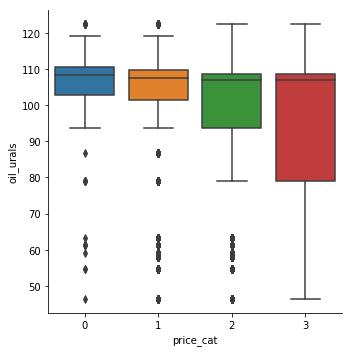

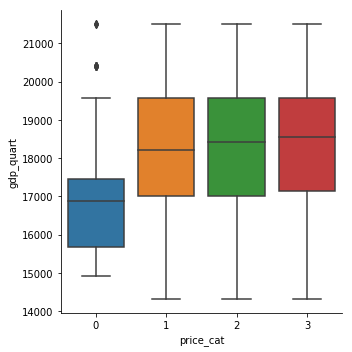

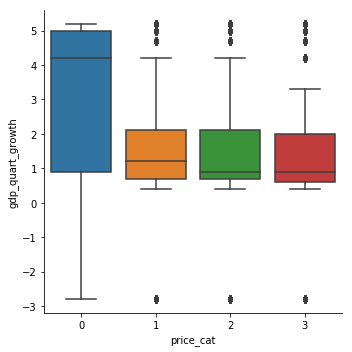

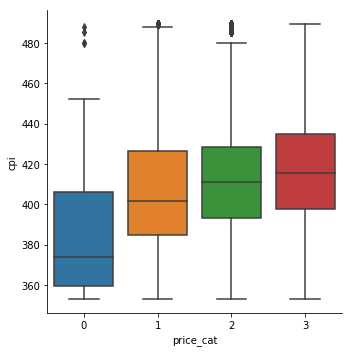

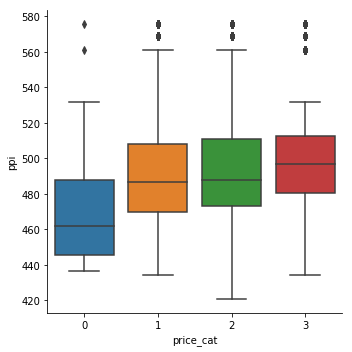

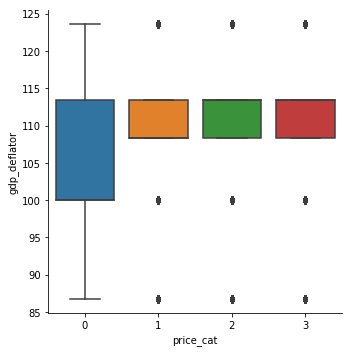

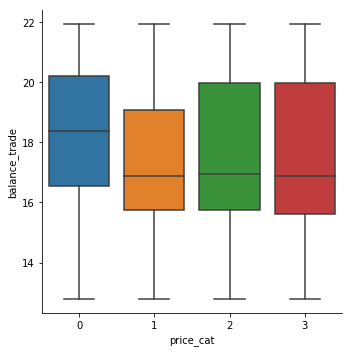

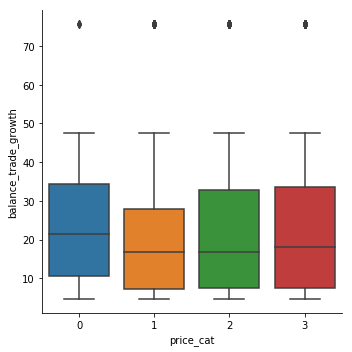

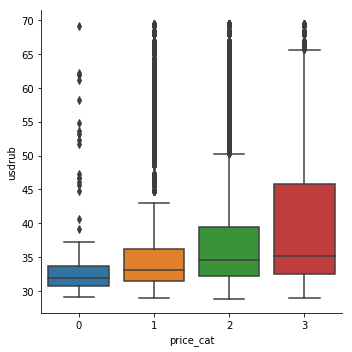

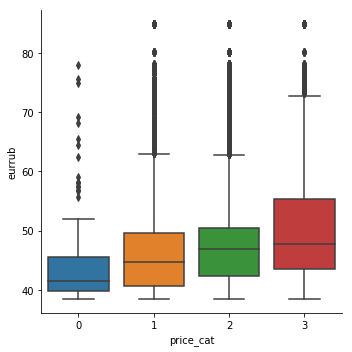

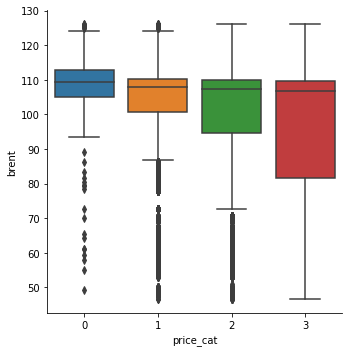

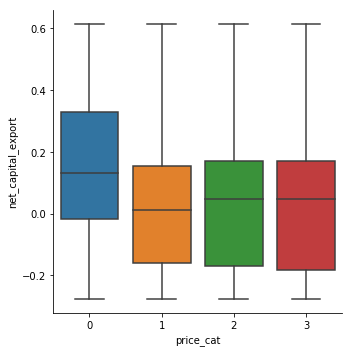

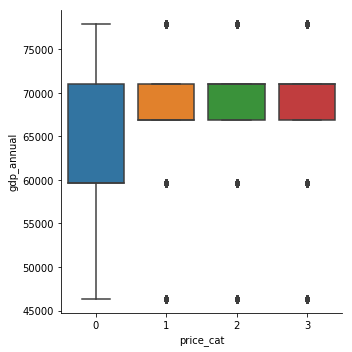

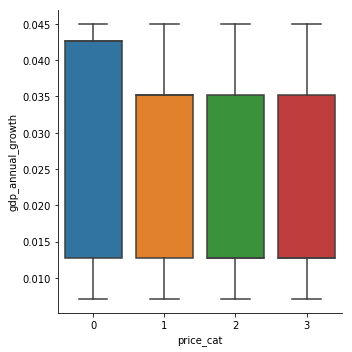

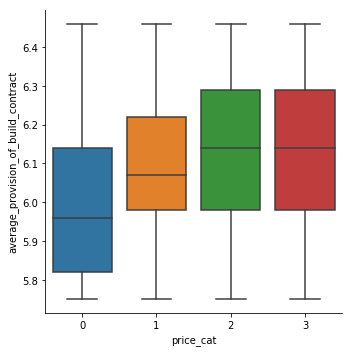

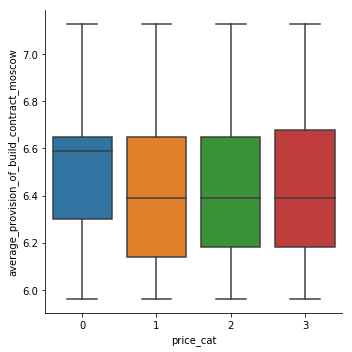

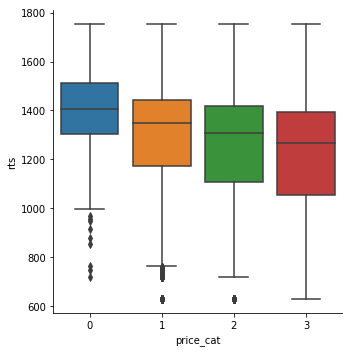

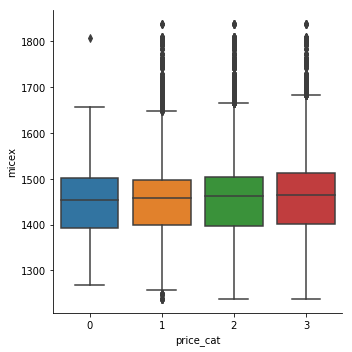

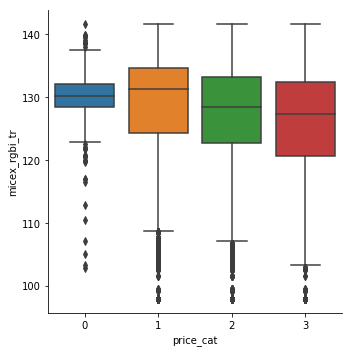

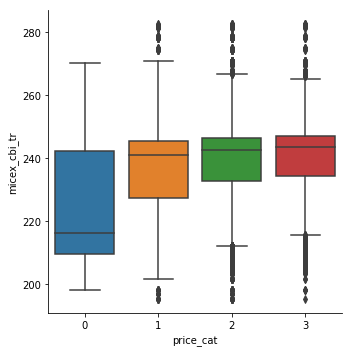

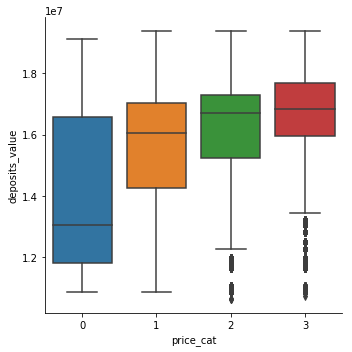

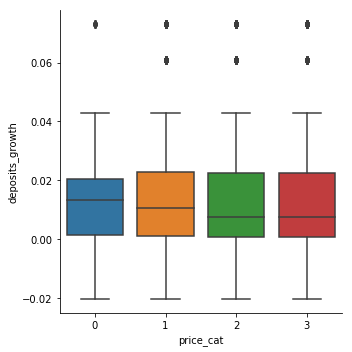

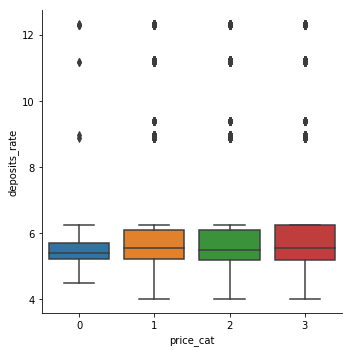

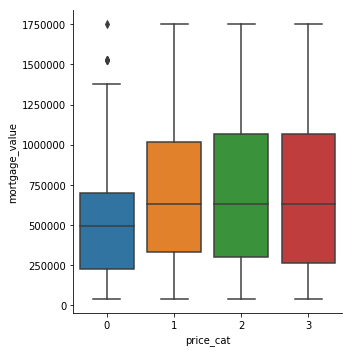

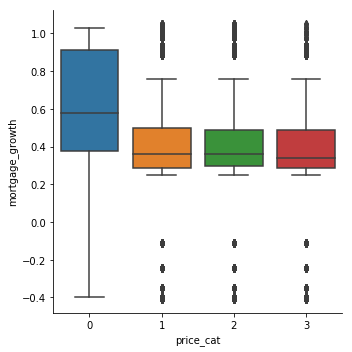

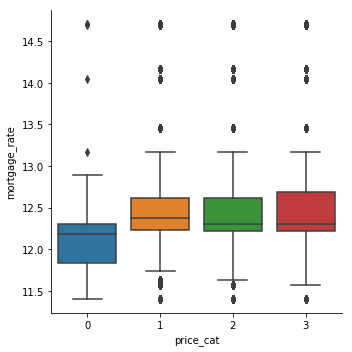

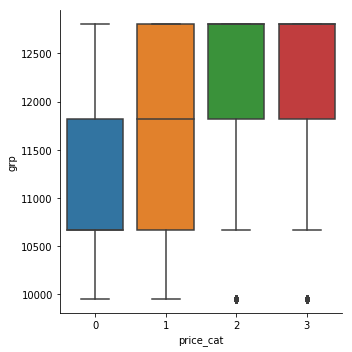

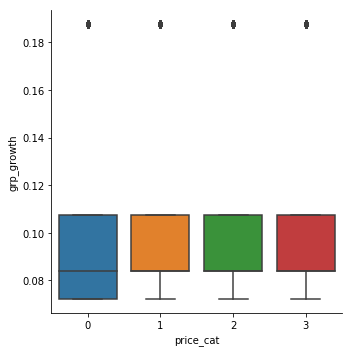

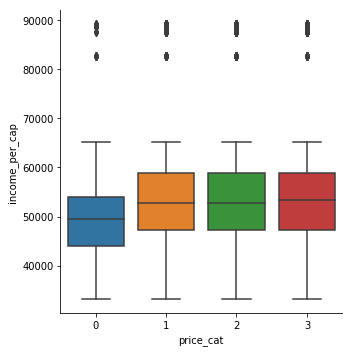

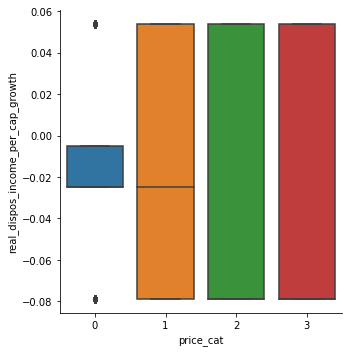

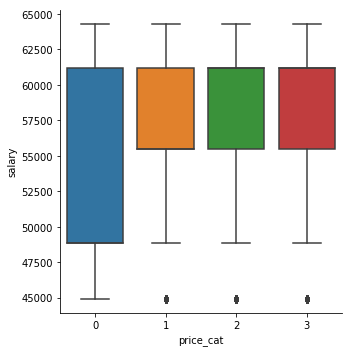

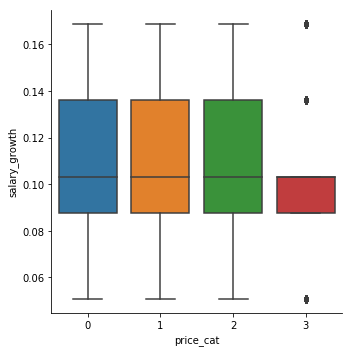

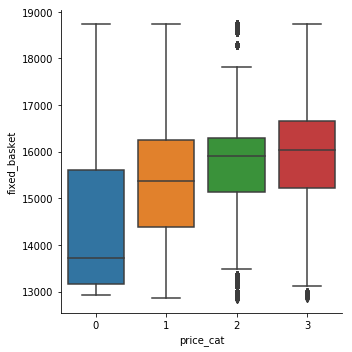

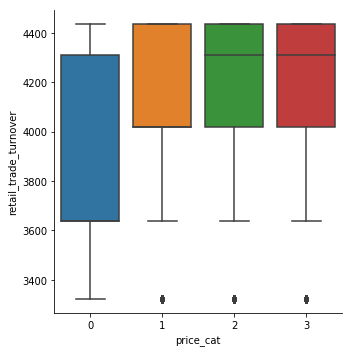

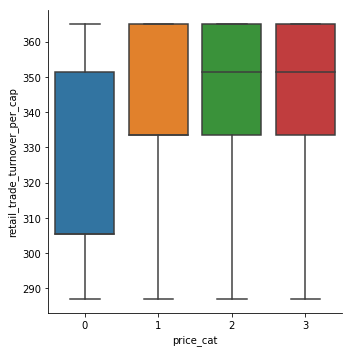

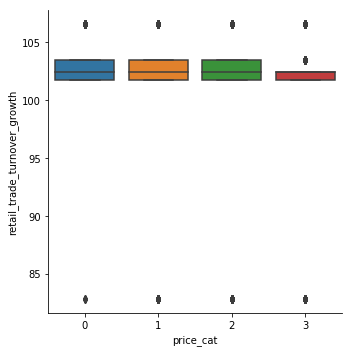

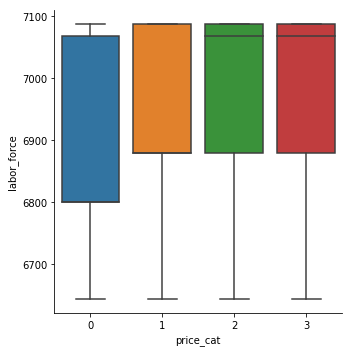

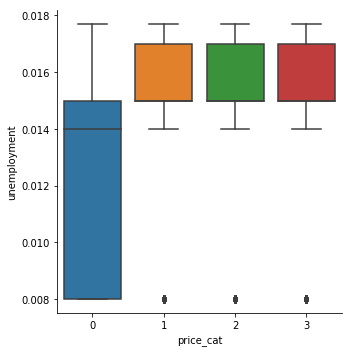

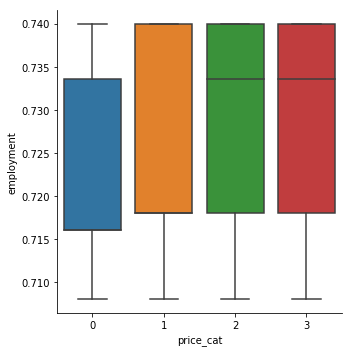

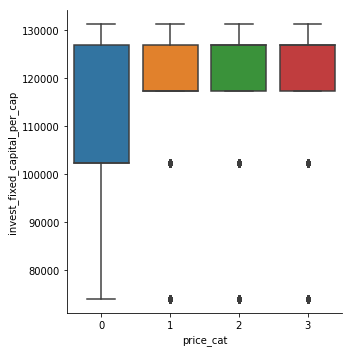

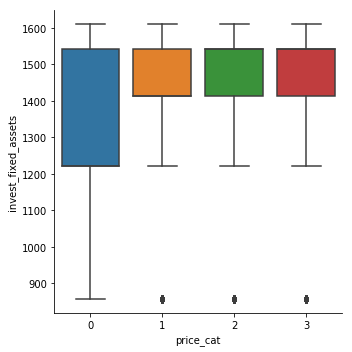

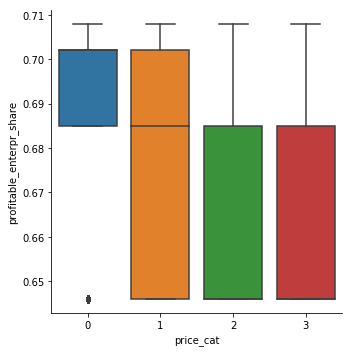

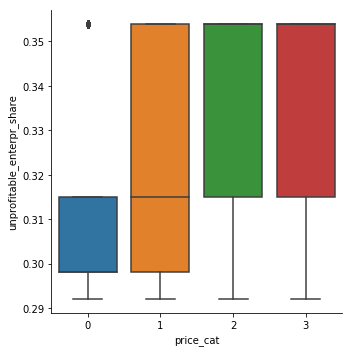

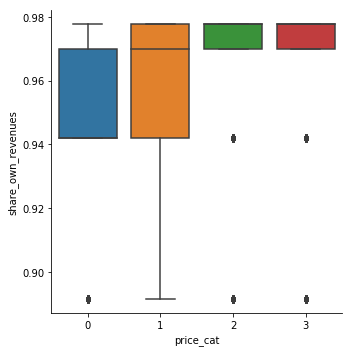

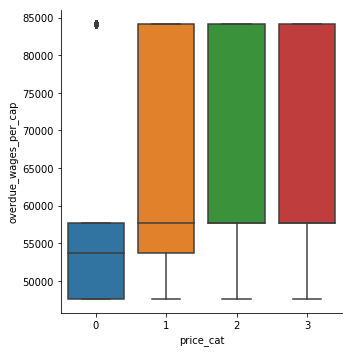

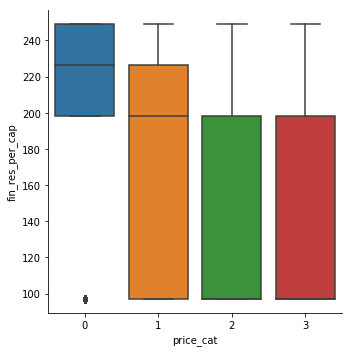

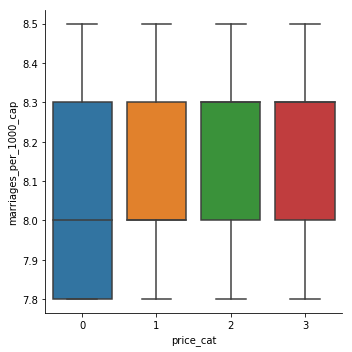

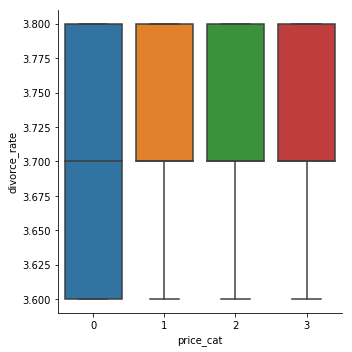

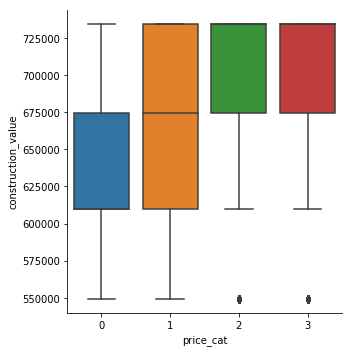

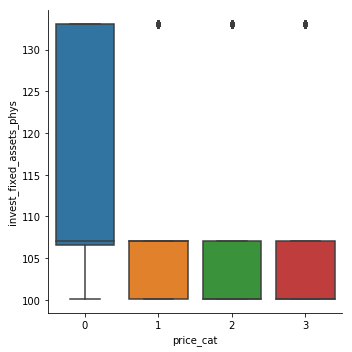

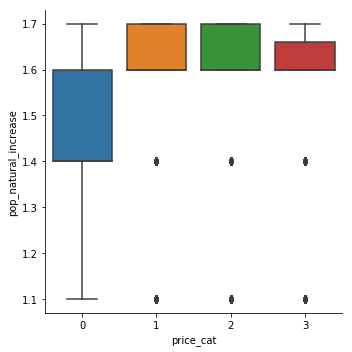

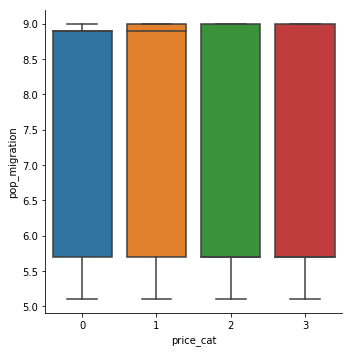

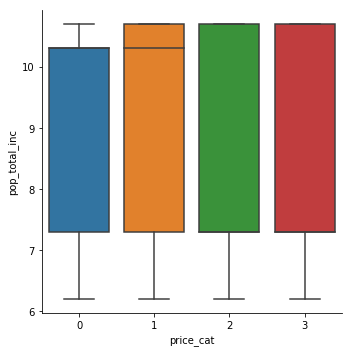

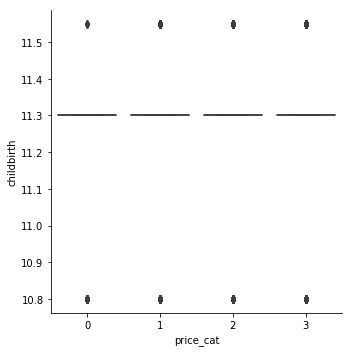

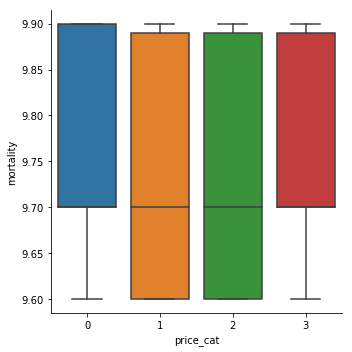

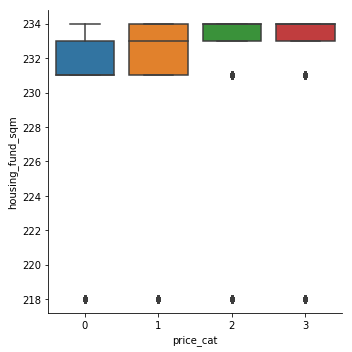

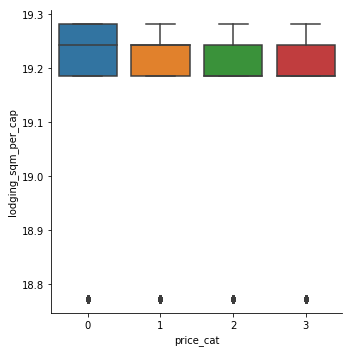

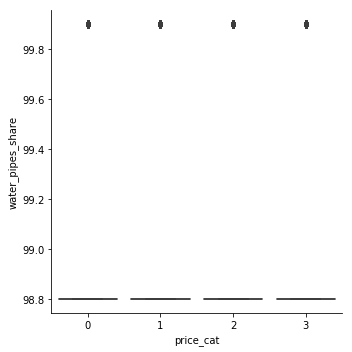

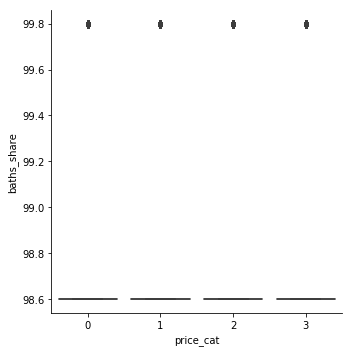

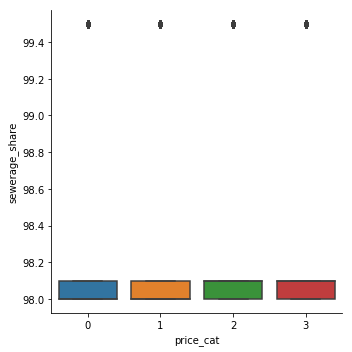

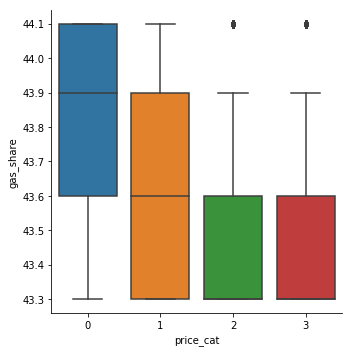

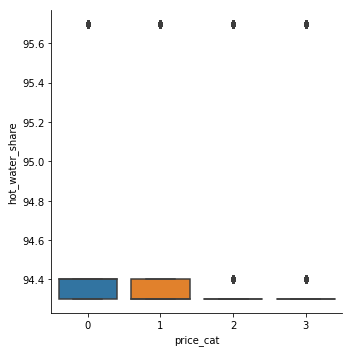

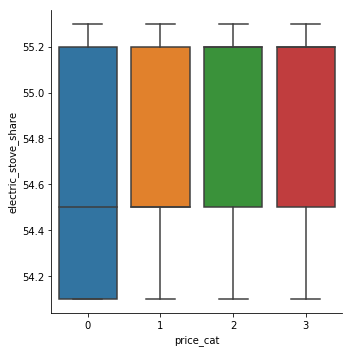

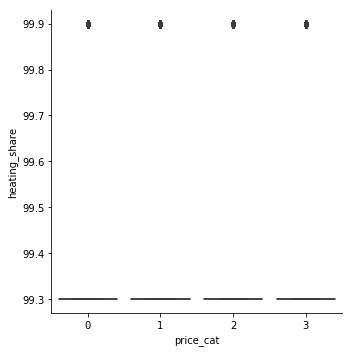

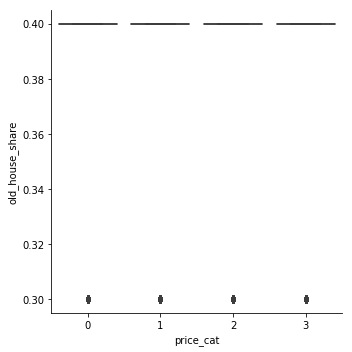

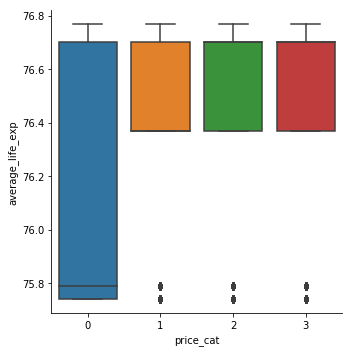

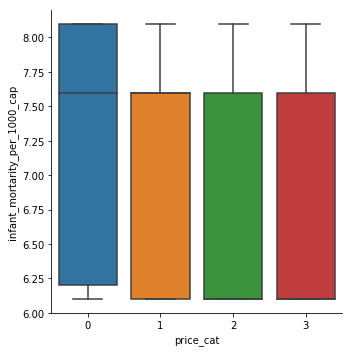

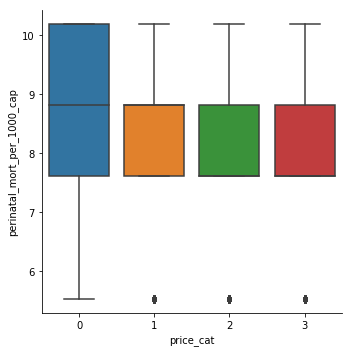

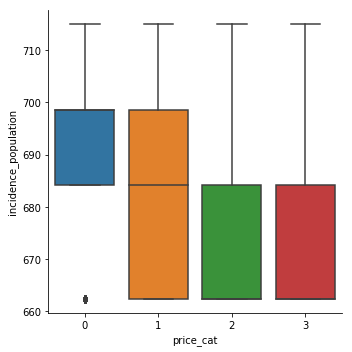

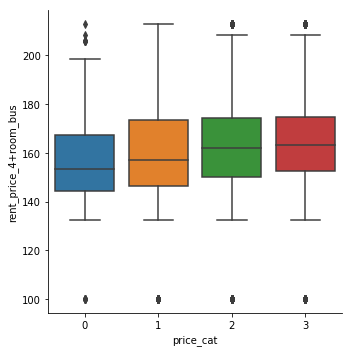

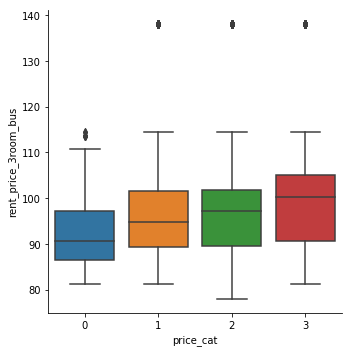

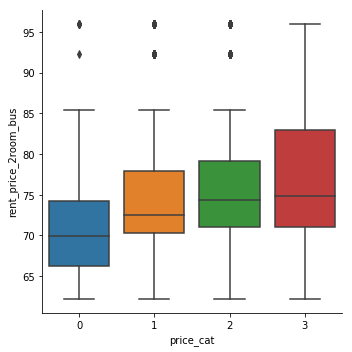

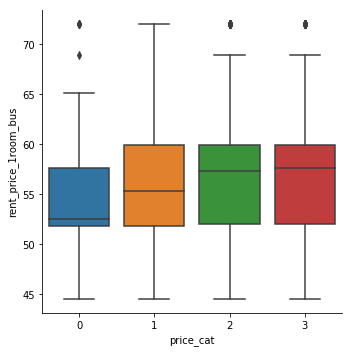

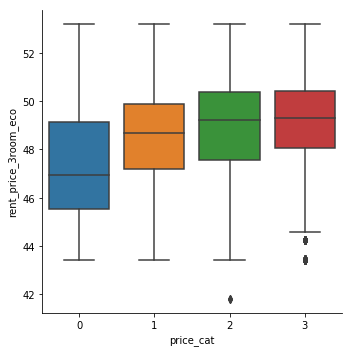

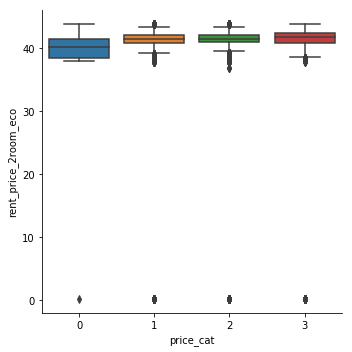

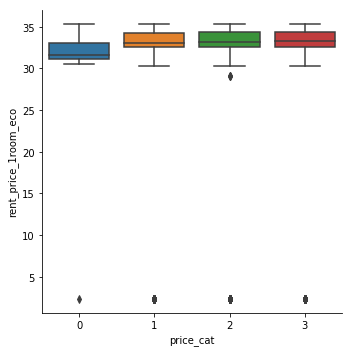

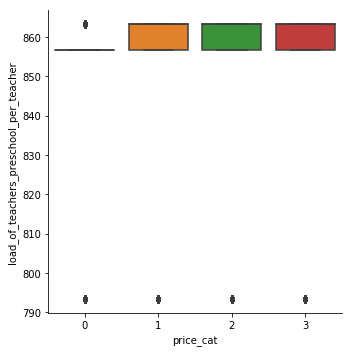

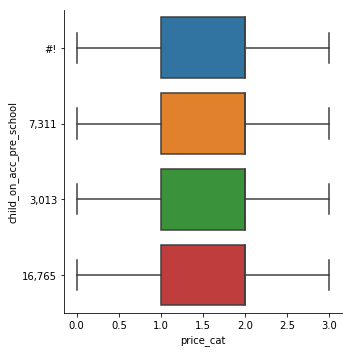

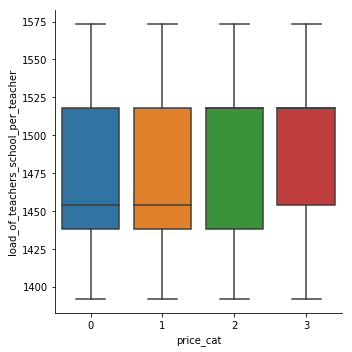

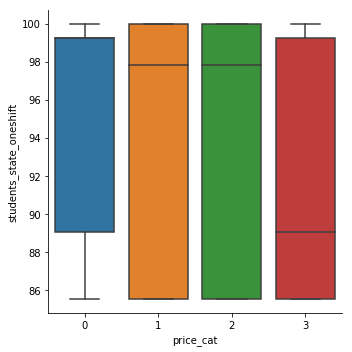

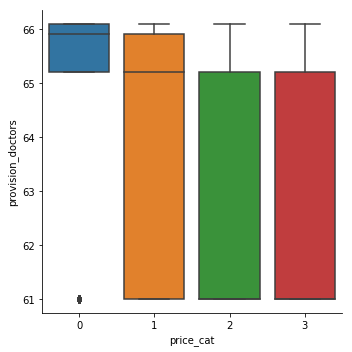

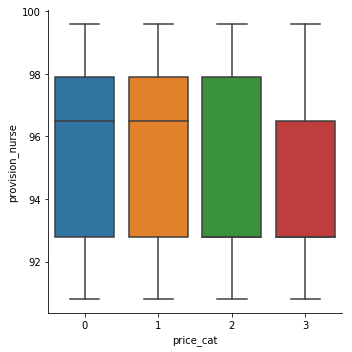

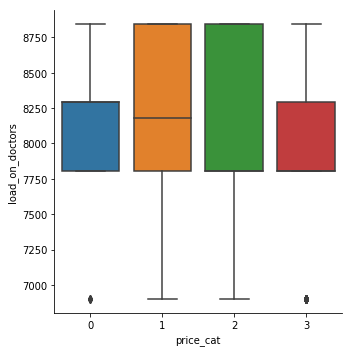

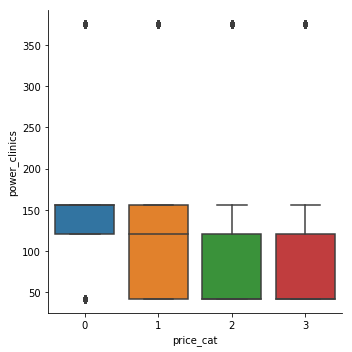

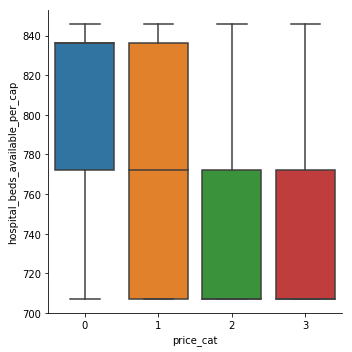

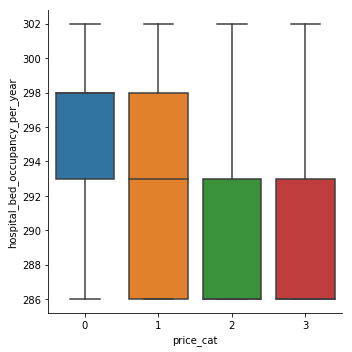

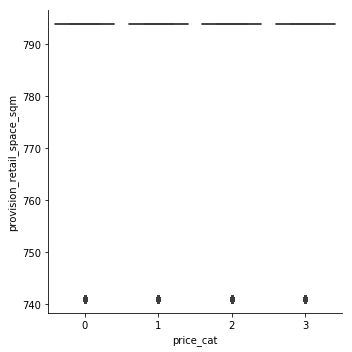

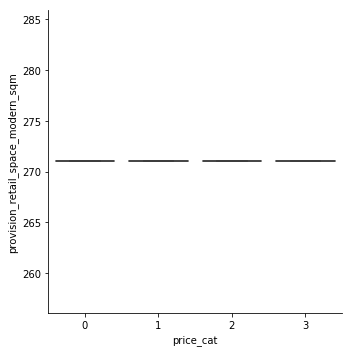

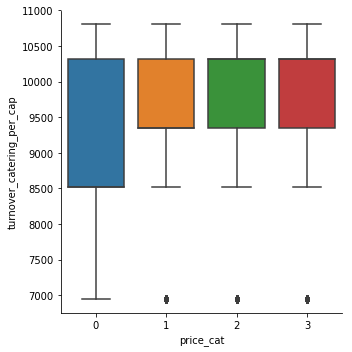

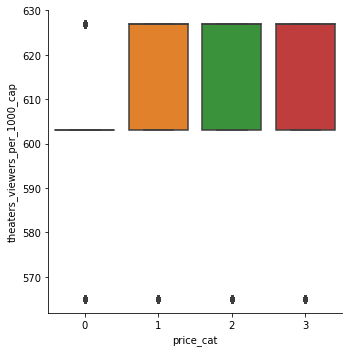

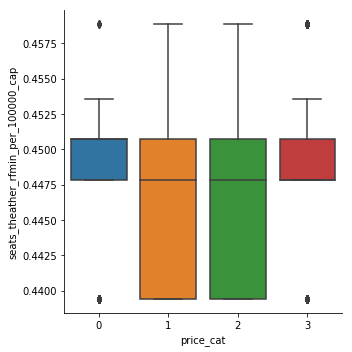

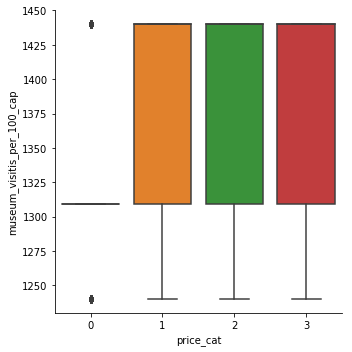

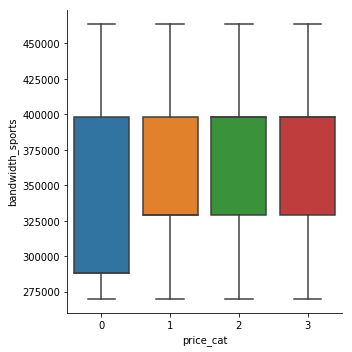

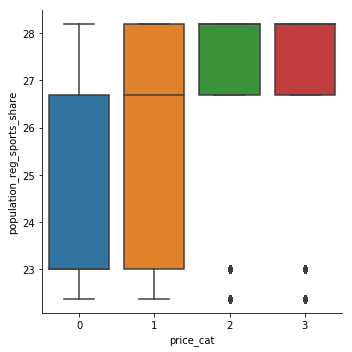

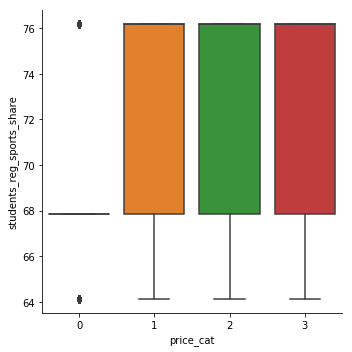

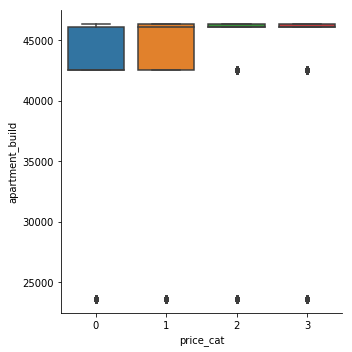

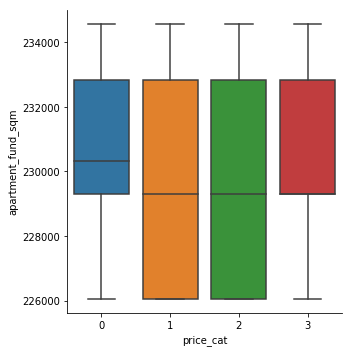

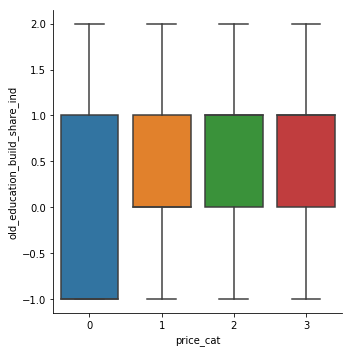

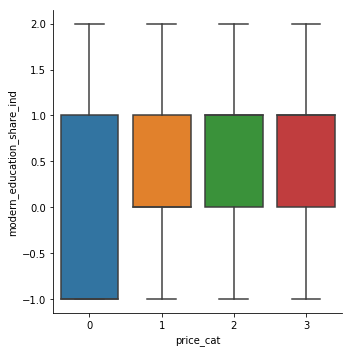

In [21]:
sk = ['timestamp', 'price_cat','price_doc']
for col in df_1.columns.values:
    if col not in sk:
        sns.catplot(x="price_cat", y=col, kind="box", data=df_1[['price_cat',col]])

In [25]:
llist = [ 'usdrub', 'eurrub', 'ppi', 'cpi', 'gdp_quart', 'gdp_quart_growth', 'brent' \
         ,'deposits_value', 'grp', 'fixed_basket', 'unemployment', 'gas_share', 'rent_price_4+room_bus'\
         , 'rent_price_3room_bus', 'rent_price_2room_bus']
llist

['usdrub',
 'eurrub',
 'ppi',
 'cpi',
 'gdp_quart',
 'gdp_quart_growth',
 'brent',
 'deposits_value',
 'grp',
 'fixed_basket',
 'unemployment',
 'gas_share',
 'rent_price_4+room_bus',
 'rent_price_3room_bus',
 'rent_price_2room_bus']

In [35]:
df_1.columns.values
pass

In [69]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(df_1.loc[:,~df_1.columns.isin(sk)], \
                                                                df_1['price_cat'], test_size=0.3)
X_train.shape

(21329, 99)

In [37]:
X_train['usdrub'].head()

3070     32.2004
20136    33.7572
8551     31.9900
11983    32.8277
24785    47.3110
Name: usdrub, dtype: float64

In [70]:
print (dt.datetime.now())
pipe = Pipeline([
       #('scaling', preprocessing.StandardScaler()),
       #('pca', PCA(whiten=True)),
       ('clf', RandomForestClassifier(random_state=0, n_jobs=2)) 
    ])

print(type(X_train))

X_train = fix_num_cols(X_train,sk)

cv = model_selection.ShuffleSplit(n_splits=5, test_size=0.2)
param_grid = { "clf__n_estimators": [500] , "clf__max_depth": [10]} #, "pca__n_components": [5, 10]}
pipe_est_cv = model_selection.GridSearchCV(pipe, param_grid=param_grid, cv=cv, \
                                           scoring='accuracy', verbose=3, n_jobs=2)

pipe_est_cv.fit(X_train, y_train)
pipe_est_cv_results = pipe_est_cv.cv_results_

print(pipe_est_cv.best_params_)
print(pipe_est_cv.best_score_)

print(pipe_est_cv_results['mean_train_score'])
print(pipe_est_cv_results['mean_test_score'])
print (dt.datetime.now())

2018-11-01 12:00:55.683346
<class 'pandas.core.frame.DataFrame'>
error: child_on_acc_pre_school
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] clf__max_depth=10, clf__n_estimators=500 ........................
[CV] clf__max_depth=10, clf__n_estimators=500 ........................
[CV]  clf__max_depth=10, clf__n_estimators=500, score=0.5353961556493202, total=   7.9s
[CV]  clf__max_depth=10, clf__n_estimators=500, score=0.5501640881387717, total=   7.9s
[CV] clf__max_depth=10, clf__n_estimators=500 ........................
[CV] clf__max_depth=10, clf__n_estimators=500 ........................
[CV]  clf__max_depth=10, clf__n_estimators=500, score=0.5550867323019222, total=   5.2s
[CV] clf__max_depth=10, clf__n_estimators=500 ........................
[CV]  clf__max_depth=10, clf__n_estimators=500, score=0.5457102672292545, total=   5.3s
[CV]  clf__max_depth=10, clf__n_estimators=500, score=0.5384435067979372, total=   4.6s


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   21.3s finished


{'clf__max_depth': 10, 'clf__n_estimators': 500}
0.5449601500234411
[0.56924339]
[0.54496015]
2018-11-01 12:01:49.203421


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [6]:
print (dt.datetime.now())

skip = ['id','timestamp', 'price_cat']
outliers = []
for col in df_eda.columns.values:
    #print(col)
    if col not in skip and not isinstance(df_eda[col][0], str):
        desc = df_eda[col].describe()
        #print('mean: ' + str(desc['mean']))
        #print('std:  ' + str(desc['std']))
        #print('max:  ' + str(desc['max']))
        three_stds = desc['mean'] * (3 * desc['std'])
        if desc['max'] >= three_stds:
            #print(col)
            #print('3 std: ' + str(three_stds) + ', ' + str(desc['max']))
            outliers.append([col,desc['mean'], desc['std'], desc['max']])

print(len(outliers))
print (dt.datetime.now())

2018-11-01 08:29:46.469831
106
2018-11-01 08:29:48.467730


In [ ]:
d = defaultdict(int)
idx_list = []
idx = []
for out in outliers:
    col = out[0]
    th_std = out[1]
    for a in df_eda[col].values:
        if a >= th_std:
            try:
                #newcol = col + '_' + 
                d[col] += 1
                idx_list.append(df_eda[col].index.get_loc(a))
            except:
                #print(th_std)
                #print('error: '+ col + ': ' +str(a))
                #idx.append(list(df_eda[df_eda[col] == a ][col].index))

#print(d)

print (dt.datetime.now())

In [179]:
skip = ['id','timestamp', 'price_cat', 'price_doc']
df_train = fix_num_cols(df_eda,skip)

#xfinal = [x[1] for x in get_cor(df_train,skip)]

xfinal = [x for x in df_train.columns.values if x not in skip]
print(len(xfinal))


#scaler = preprocessing.StandardScaler(copy=True)
#print(scaler.fit(df_train[xfinal]))
#print(scaler.mean_)
#print(scaler.transform(df_train[xfinal]).shape)

#df_train = pd.DataFrame(scaler.transform(df_train[xfinal]), columns=xfinal)
#df_train['sub_area'] = df_eda['sub_area'].astype('category').cat.codes
df_train = pd.get_dummies(df_train[xfinal])
xfinal = [col for col in df_train.columns.values]
df_train['price_cat'] = df_eda['price_cat']
df_train['price_cat_str'] = ['lvl_' + str(l) for l in df_train['price_cat'].values]

X_train, X_test, y_train, y_test = model_selection.train_test_split(df_train[xfinal], \
                                                                df_train['price_cat'], test_size=0.3)
print(len(xfinal))

388
553


In [180]:
df_train['price_cat_str'].head()

0    lvl_2
1    lvl_2
2    lvl_2
3    lvl_3
4    lvl_3
Name: price_cat_str, dtype: object

In [9]:
print (dt.datetime.now())
clf = RandomForestClassifier(n_estimators=500, max_depth=10,random_state=0, n_jobs=2)
print(clf.fit(X_train, y_train))
print(clf.score(X_train,y_train))
print(clf.score(X_test,y_test))
print (dt.datetime.now())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=2,
            oob_score=False, random_state=0, verbose=0, warm_start=False)
0.8250738431243846
0.7887770728505797
2018-10-30 08:17:41.046769


In [72]:
# Train Test Split
skip = ['id','timestamp', 'price_cat', 'price_doc']
df_train = fix_num_cols(df_eda,skip)

xfinal = [x[1] for x in get_cor(df_train,skip)]
print(len(xfinal))

X_train, X_test, y_train, y_test = model_selection.train_test_split(df_train[xfinal], \
                                                                df_train['price_cat'], test_size=0.3)
X_train.shape

error: product_type
error: sub_area
error: culture_objects_top_25
error: thermal_power_plant_raion
error: incineration_raion
error: oil_chemistry_raion
error: radiation_raion
error: railroad_terminal_raion
error: big_market_raion
error: nuclear_reactor_raion
error: detention_facility_raion
error: water_1line
error: big_road1_1line
error: railroad_1line
error: ecology
error: child_on_acc_pre_school
371


(21329, 371)

In [167]:
# Import H2O RF:
import h2o
#from h2o.estimators.random_forest import H2ORandomForestEstimator
!which python
#!pip install h2o
h2o.init(nthreads = -1, max_mem_size = 8)

/Users/chadleonard/Springboard/anaconda3/bin/python
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "9.0.1"; Java(TM) SE Runtime Environment (build 9.0.1+11); Java HotSpot(TM) 64-Bit Server VM (build 9.0.1+11, mixed mode)
  Starting server from /Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/jt/865lf3wn4lxgdrwjk2r2m8bw0000gn/T/tmpsxpy750u
  JVM stdout: /var/folders/jt/865lf3wn4lxgdrwjk2r2m8bw0000gn/T/tmpsxpy750u/h2o_chadleonard_started_from_python.out
  JVM stderr: /var/folders/jt/865lf3wn4lxgdrwjk2r2m8bw0000gn/T/tmpsxpy750u/h2o_chadleonard_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,07 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.0.1
H2O cluster version age:,4 days
H2O cluster name:,H2O_from_python_chadleonard_995zlp
H2O cluster total nodes:,1
H2O cluster free memory:,8 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


In [181]:
print (dt.datetime.now())
data = h2o.H2OFrame(df_train)
print (dt.datetime.now())

/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/h2o/utils/shared_utils.py:177: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%


In [188]:
print (dt.datetime.now())
data['price_cat'] = data['price_cat'].asfactor() 
splits = data.split_frame(ratios=[0.7], seed=1)  

train = splits[0]
#valid = splits[1]
test = splits[1]
print (dt.datetime.now())

2018-10-31 12:40:05.074232
2018-10-31 12:40:07.879233


In [185]:
print(len(train))
print(len(test))

21435
9036


In [198]:
print (dt.datetime.now())
rf_fit1 = H2ORandomForestEstimator(model_id='rf_fit1', seed=1, ntrees=50, max_depth=20, nfolds=10)

rf_fit1.train(x=xfinal, y='price_cat', training_frame=train )
print (dt.datetime.now())

2018-10-31 13:00:02.074986
drf Model Build progress: |███████████████████████████████████████████████| 100%
2018-10-31 14:01:17.102609


In [199]:
print (dt.datetime.now())
rf_perf1 = rf_fit1.model_performance(test)
print (rf_perf1)
print (dt.datetime.now())

2018-10-31 15:00:34.138459

ModelMetricsMultinomial: drf
** Reported on test data. **

MSE: 0.19486634606063377
RMSE: 0.44143668409029374
LogLoss: 0.6688788152863605
Mean Per-Class Error: 0.43370862685034434
Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



0,1,2,3,Error,Rate
4.0,12.0,51.0,7.0,0.9459459,70 / 74
0.0,1469.0,983.0,96.0,0.4234694,"1,079 / 2,548"
2.0,315.0,4495.0,163.0,0.0964824,"480 / 4,975"
4.0,12.0,371.0,1052.0,0.2689368,"387 / 1,439"
10.0,1808.0,5900.0,1318.0,0.2231076,"2,016 / 9,036"


Top-4 Hit Ratios: 


k,hit_ratio
1,0.7768924
2,0.9555113
3,0.9933599
4,1.0



2018-10-31 15:00:46.609510


In [201]:
# RandomForestClassifier with RandomizedSearchCV

print (dt.datetime.now())

from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
print (dt.datetime.now())
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,\
                               n_iter = 10, cv = 3, verbose=3, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

rf_random.best_params_

print (dt.datetime.now())

2018-10-31 15:38:07.542369
2018-10-31 15:38:07.659973
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True [CV] n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True 

[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=True 
[CV] n_estimators=600, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=False 
[CV] n_estimators=600, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=False 
[CV] n_estimators=600, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=False 
[CV] n_estimators=600, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=60, bootstrap=False 
[CV] n_estimators=600, min_samples_split=2, min_samples_leaf=2, max_features=auto, m

[Parallel(n_jobs=-1)]: Done  26 out of  30 | elapsed: 30.2min remaining:  4.6min


[CV]  n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=50, bootstrap=False, score=0.780059063422866, total=19.9min[CV]  n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=50, bootstrap=False, score=0.7832630098452883, total=19.8min[CV]  n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=50, bootstrap=False, score=0.7824985931344963, total=19.1min


[CV]  n_estimators=2000, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=50, bootstrap=True, score=0.7874226223972988, total=11.1min


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 34.0min finished


2018-10-31 16:18:54.646009


In [73]:
# Random Forest Classifier with median for NaNs
print (dt.datetime.now())
pipe = Pipeline([
   ('clf', RandomForestClassifier(random_state=0, n_jobs=2)) 
    ])


cv = model_selection.ShuffleSplit(n_splits=5, test_size=0.2)
param_grid = { "clf__n_estimators": [500] , "clf__max_depth": [10]}
pipe_est_cv = model_selection.GridSearchCV(pipe, param_grid=param_grid, cv=cv,scoring='accuracy',\
                                           n_jobs=2,verbose=3)

pipe_est_cv.fit(X_train, y_train)
pipe_est_cv_results = pipe_est_cv.cv_results_

print(pipe_est_cv_results['params'])
print(pipe_est_cv_results['mean_train_score'])
print(pipe_est_cv_results['mean_test_score'])
print (dt.datetime.now())

2018-11-01 12:08:56.307384
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] clf__max_depth=10, clf__n_estimators=500 ........................
[CV] clf__max_depth=10, clf__n_estimators=500 ........................
[CV]  clf__max_depth=10, clf__n_estimators=500, score=0.7852789498359118, total=  21.0s
[CV]  clf__max_depth=10, clf__n_estimators=500, score=0.7880918893577121, total=  21.0s
[CV] clf__max_depth=10, clf__n_estimators=500 ........................
[CV] clf__max_depth=10, clf__n_estimators=500 ........................
[CV]  clf__max_depth=10, clf__n_estimators=500, score=0.789732770745429, total=  20.6s
[CV]  clf__max_depth=10, clf__n_estimators=500, score=0.7733239568682607, total=  20.7s
[CV] clf__max_depth=10, clf__n_estimators=500 ........................
[CV]  clf__max_depth=10, clf__n_estimators=500, score=0.7836380684481951, total=  21.2s


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.1min finished


[{'clf__max_depth': 10, 'clf__n_estimators': 500}]
[0.83206939]
[0.78401313]
2018-11-01 12:10:33.195310


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [78]:
X_train.shape

(21329, 371)

In [79]:
# First XGBoost Classifier model
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
# load data

print (dt.datetime.now())
pipe = Pipeline([
      # ('scaling', preprocessing.StandardScaler()),
       #('pca', PCA(whiten=True)),
       ('clf', XGBClassifier()) 
    ])

cv = model_selection.ShuffleSplit(n_splits=5, test_size=0.2)
param_grid = { "clf__n_estimators": [200], \
              "clf__objective": ['multi:softmax', 'multi:softprob'] , "clf__max_depth": [10]}
pipe_est_cv = model_selection.GridSearchCV(pipe, param_grid=param_grid, cv=cv, \
                                           scoring='accuracy', verbose=3, n_jobs=2)

pipe_est_cv.fit(X_train, y_train)
pipe_est_cv_results = pipe_est_cv.cv_results_

print(pipe_est_cv.best_params_)
print(pipe_est_cv.best_score_)

print(pipe_est_cv_results['mean_train_score'])
print(pipe_est_cv_results['mean_test_score'])
print (dt.datetime.now())

# fit model no training data
#model = XGBClassifier()
#model.fit(X_train, y_train)
# make predictions for test data
#y_pred = model.predict(X_test)
#predictions = [round(value) for value in y_pred]
# evaluate predictions
#accuracy = accuracy_score(y_test, predictions)
#print("Accuracy: %.2f%%" % (accuracy * 100.0))

2018-11-01 16:02:53.944592
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] clf__max_depth=10, clf__n_estimators=200, clf__objective=multi:softmax 
[CV] clf__max_depth=10, clf__n_estimators=200, clf__objective=multi:softmax 


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  clf__max_depth=10, clf__n_estimators=200, clf__objective=multi:softmax, score=0.8166901078293484, total=10.4min
[CV] clf__max_depth=10, clf__n_estimators=200, clf__objective=multi:softmax 


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  clf__max_depth=10, clf__n_estimators=200, clf__objective=multi:softmax, score=0.8164556962025317, total=10.5min
[CV] clf__max_depth=10, clf__n_estimators=200, clf__objective=multi:softmax 


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  clf__max_depth=10, clf__n_estimators=200, clf__objective=multi:softmax, score=0.8127051101734646, total=10.3min
[CV] clf__max_depth=10, clf__n_estimators=200, clf__objective=multi:softmax 


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  clf__max_depth=10, clf__n_estimators=200, clf__objective=multi:softmax, score=0.8143459915611815, total=10.3min
[CV] clf__max_depth=10, clf__n_estimators=200, clf__objective=multi:softprob 


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  clf__max_depth=10, clf__n_estimators=200, clf__objective=multi:softmax, score=0.8220815752461322, total=10.5min
[CV] clf__max_depth=10, clf__n_estimators=200, clf__objective=multi:softprob 


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  clf__max_depth=10, clf__n_estimators=200, clf__objective=multi:softprob, score=0.8164556962025317, total=10.5min
[CV] clf__max_depth=10, clf__n_estimators=200, clf__objective=multi:softprob 


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  clf__max_depth=10, clf__n_estimators=200, clf__objective=multi:softprob, score=0.8127051101734646, total=10.4min
[CV] clf__max_depth=10, clf__n_estimators=200, clf__objective=multi:softprob 


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  clf__max_depth=10, clf__n_estimators=200, clf__objective=multi:softprob, score=0.8166901078293484, total=10.5min
[CV] clf__max_depth=10, clf__n_estimators=200, clf__objective=multi:softprob 


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  clf__max_depth=10, clf__n_estimators=200, clf__objective=multi:softprob, score=0.8143459915611815, total=10.2min


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  clf__max_depth=10, clf__n_estimators=200, clf__objective=multi:softprob, score=0.8220815752461322, total=10.2min


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed: 52.2min finished


{'clf__max_depth': 10, 'clf__n_estimators': 200, 'clf__objective': 'multi:softmax'}
0.8164556962025317
[0.9998359 0.9998359]
[0.8164557 0.8164557]
2018-11-01 17:08:18.341887


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [10]:
# Random Forest Classifier with PCA
print (dt.datetime.now())
pipe = Pipeline([
       ('scaling', preprocessing.StandardScaler()),
       ('pca', PCA(whiten=True)),
       ('clf', RandomForestClassifier(random_state=0, n_jobs=2)) 
    ])

cv = model_selection.ShuffleSplit(n_splits=5, test_size=0.2)
param_grid = { "clf__n_estimators": [500] , "clf__max_depth": [10], "pca__n_components": [50, 100]}
pipe_est_cv = model_selection.GridSearchCV(pipe, param_grid=param_grid, cv=cv, scoring='accuracy', verbose=3, n_jobs=2)

pipe_est_cv.fit(X_train, y_train)
pipe_est_cv_results = pipe_est_cv.cv_results_

print(pipe_est_cv.best_params_)
print(pipe_est_cv.best_score_)

print(pipe_est_cv_results['mean_train_score'])
print(pipe_est_cv_results['mean_test_score'])
print (dt.datetime.now())

2018-10-30 15:42:17.823359
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] clf__max_depth=10, clf__n_estimators=500, pca__n_components=50 ..
[CV] clf__max_depth=10, clf__n_estimators=500, pca__n_components=50 ..
[CV]  clf__max_depth=10, clf__n_estimators=500, pca__n_components=50, score=0.7140178152836381, total=  24.2s
[CV]  clf__max_depth=10, clf__n_estimators=500, pca__n_components=50, score=0.7189404594467885, total=  24.3s
[CV] clf__max_depth=10, clf__n_estimators=500, pca__n_components=50 ..
[CV] clf__max_depth=10, clf__n_estimators=500, pca__n_components=50 ..
[CV]  clf__max_depth=10, clf__n_estimators=500, pca__n_components=50, score=0.7163619315518049, total=  26.0s
[CV]  clf__max_depth=10, clf__n_estimators=500, pca__n_components=50, score=0.7090951711204876, total=  26.0s
[CV] clf__max_depth=10, clf__n_estimators=500, pca__n_components=50 ..
[CV] clf__max_depth=10, clf__n_estimators=500, pca__n_components=100 .
[CV]  clf__max_depth=10, clf__n_estimators=500,

[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:  2.8min finished


[{'clf__max_depth': 10, 'clf__n_estimators': 500, 'pca__n_components': 50}, {'clf__max_depth': 10, 'clf__n_estimators': 500, 'pca__n_components': 100}]
[0.77670984 0.77510403]
[0.7140647  0.70337553]
2018-10-30 15:45:37.636497


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [29]:
# Gradient Boosting Classifier with PCA
from sklearn.ensemble import GradientBoostingClassifier

print (dt.datetime.now())
pipe = Pipeline([
       ('scaling', preprocessing.StandardScaler()),
       ('pca', PCA(whiten=True)),
       ('clf', GradientBoostingClassifier())
    ])

cv = model_selection.ShuffleSplit(n_splits=5, test_size=0.2)
param_grid = { "clf__n_estimators": [500] , "pca__n_components": [50, 100]}
pipe_est_cv = model_selection.GridSearchCV(pipe, param_grid=param_grid, cv=cv, scoring='accuracy', verbose=3, n_jobs=2)

pipe_est_cv.fit(X_train, y_train)
pipe_est_cv_results = pipe_est_cv.cv_results_

print(pipe_est_cv.best_params_)
print(pipe_est_cv.best_score_)

print(pipe_est_cv_results['mean_train_score'])
print(pipe_est_cv_results['mean_test_score'])
print (dt.datetime.now())


2018-10-30 16:59:10.770984
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] clf__n_estimators=500, pca__n_components=50 .....................
[CV] clf__n_estimators=500, pca__n_components=50 .....................
[CV]  clf__n_estimators=500, pca__n_components=50, score=0.7644163150492265, total= 3.6min
[CV]  clf__n_estimators=500, pca__n_components=50, score=0.7311298640412565, total= 3.6min
[CV] clf__n_estimators=500, pca__n_components=50 .....................
[CV] clf__n_estimators=500, pca__n_components=50 .....................
[CV]  clf__n_estimators=500, pca__n_components=50, score=0.7243319268635724, total= 3.5min
[CV] clf__n_estimators=500, pca__n_components=50 .....................
[CV]  clf__n_estimators=500, pca__n_components=50, score=0.7449601500234412, total= 3.5min
[CV] clf__n_estimators=500, pca__n_components=100 ....................
[CV]  clf__n_estimators=500, pca__n_components=50, score=0.736755743084857, total= 3.6min
[CV] clf__n_estimators=500, pca__

[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed: 29.3min finished


{'clf__n_estimators': 500, 'pca__n_components': 100}
0.7520393811533052
[0.84006329 0.87588349]
[0.7403188  0.75203938]
2018-10-30 17:37:52.823814


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [66]:
# Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier

print (dt.datetime.now())
pipe = Pipeline([
   ('clf', GradientBoostingClassifier()) 
    ])

cv = model_selection.ShuffleSplit(n_splits=5, test_size=0.2)
param_grid = { "clf__n_estimators": [100,500] }
pipe_est_cv = model_selection.GridSearchCV(pipe,param_grid=param_grid,cv=cv,scoring='accuracy',verbose=2,n_jobs=2)

pipe_est_cv.fit(X_train, y_train)
pipe_est_cv_results = pipe_est_cv.cv_results_

print(pipe_est_cv.best_params_)
print(pipe_est_cv.best_score_)

print(pipe_est_cv_results['mean_train_score'])
print(pipe_est_cv_results['mean_test_score'])
print (dt.datetime.now())


2018-10-30 11:56:38.423094
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] clf__n_estimators=100 ...........................................
[CV] clf__n_estimators=100 ...........................................
[CV] ............................ clf__n_estimators=100, total= 1.9min
[CV] clf__n_estimators=100 ...........................................
[CV] ............................ clf__n_estimators=100, total= 1.9min
[CV] clf__n_estimators=100 ...........................................
[CV] ............................ clf__n_estimators=100, total= 1.9min
[CV] ............................ clf__n_estimators=100, total= 1.9min
[CV] clf__n_estimators=100 ...........................................
[CV] clf__n_estimators=500 ...........................................
[CV] ............................ clf__n_estimators=100, total= 1.9min
[CV] clf__n_estimators=500 ...........................................
[CV] ............................ clf__n_estimators=500, tota

[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed: 29.7min finished


{'clf__n_estimators': 500}
0.8034224097515237
[0.82452089 0.89333646]
[0.79962494 0.80342241]
2018-10-30 12:37:03.266426


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [65]:
# svm SVC Classifier
from sklearn.svm import SVC

print (dt.datetime.now())
pipe = Pipeline([
   ('clf', SVC()) 
    ])

cv = model_selection.ShuffleSplit(n_splits=5, test_size=0.2)
param_grid = { "clf__kernel": ['rbf', 'sigmoid'] }
pipe_est_cv = model_selection.GridSearchCV(pipe,param_grid=param_grid,cv=cv,scoring='accuracy',verbose=2,n_jobs=2)

pipe_est_cv.fit(X_train, y_train)
pipe_est_cv_results = pipe_est_cv.cv_results_

print(pipe_est_cv.best_params_)
print(pipe_est_cv.best_score_)

print(pipe_est_cv_results['mean_train_score'])
print(pipe_est_cv_results['mean_test_score'])
print (dt.datetime.now())


2018-10-30 11:31:15.474800
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] clf__kernel=rbf .................................................
[CV] clf__kernel=rbf .................................................
[CV] .................................. clf__kernel=rbf, total= 2.5min
[CV] clf__kernel=rbf .................................................
[CV] .................................. clf__kernel=rbf, total= 2.5min
[CV] clf__kernel=rbf .................................................
[CV] .................................. clf__kernel=rbf, total= 2.4min
[CV] clf__kernel=rbf .................................................
[CV] .................................. clf__kernel=rbf, total= 2.4min
[CV] clf__kernel=sigmoid .............................................
[CV] .............................. clf__kernel=sigmoid, total= 2.2min
[CV] clf__kernel=sigmoid .............................................
[CV] .................................. clf__kernel=rbf, tota

[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed: 18.7min finished


{'clf__kernel': 'rbf'}
0.7557430848570089
[0.77883139 0.50494051]
[0.75574308 0.50070323]
2018-10-30 11:53:00.379640


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [59]:
# Ridge Classifier
from sklearn.linear_model import RidgeClassifierCV

print (dt.datetime.now())
pipe = Pipeline([
   ('clf', RidgeClassifierCV()) 
    ])

cv = model_selection.ShuffleSplit(n_splits=5, test_size=0.2)
param_grid = { "clf__normalize": [True, False] }
pipe_est_cv = model_selection.GridSearchCV(pipe,param_grid=param_grid,cv=cv,scoring='accuracy',verbose=2,n_jobs=2)

pipe_est_cv.fit(X_train, y_train)
pipe_est_cv_results = pipe_est_cv.cv_results_

print(pipe_est_cv.best_params_)
print(pipe_est_cv.best_score_)

print(pipe_est_cv_results['mean_train_score'])
print(pipe_est_cv_results['mean_test_score'])
print (dt.datetime.now())


2018-10-30 11:22:10.894632
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] clf__normalize=True .............................................
[CV] clf__normalize=True .............................................
[CV] .............................. clf__normalize=True, total=   2.2s
[CV] .............................. clf__normalize=True, total=   2.5s
[CV] clf__normalize=True .............................................
[CV] clf__normalize=True .............................................
[CV] .............................. clf__normalize=True, total=   1.5s
[CV] clf__normalize=True .............................................
[CV] .............................. clf__normalize=True, total=   1.6s
[CV] clf__normalize=False ............................................
[CV] .............................. clf__normalize=True, total=   1.4s
[CV] clf__normalize=False ............................................
[CV] ............................. clf__normalize=False, tota

[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    9.7s finished


{'clf__normalize': False}
0.6767463666197844
[0.68102913 0.68720624]
[0.67487107 0.67674637]
2018-10-30 11:22:22.103023


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [28]:
# Ridge Classifier with PCA
from sklearn.linear_model import RidgeClassifier

print (dt.datetime.now())
pipe = Pipeline([
       ('scaling', preprocessing.StandardScaler()),
       ('pca', PCA(whiten=True)),
       ('clf', RidgeClassifier())
    ])

cv = model_selection.ShuffleSplit(n_splits=5, test_size=0.2)
param_grid = { "clf__solver": ['sag', 'lsqr'], "pca__n_components": [50, 100] }
pipe_est_cv = model_selection.GridSearchCV(pipe, param_grid=param_grid, cv=cv, scoring='accuracy', \
                                           verbose=3, n_jobs=2)

pipe_est_cv.fit(X_train, y_train)
pipe_est_cv_results = pipe_est_cv.cv_results_

print(pipe_est_cv.best_params_)
print(pipe_est_cv.best_score_)

print(pipe_est_cv_results['mean_train_score'])
print(pipe_est_cv_results['mean_test_score'])
print (dt.datetime.now())


2018-10-30 16:49:48.509404
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] clf__solver=sag, pca__n_components=50 ...........................
[CV] clf__solver=sag, pca__n_components=50 ...........................
[CV]  clf__solver=sag, pca__n_components=50, score=0.6523675574308486, total=   2.6s
[CV]  clf__solver=sag, pca__n_components=50, score=0.6570557899671824, total=   2.7s
[CV] clf__solver=sag, pca__n_components=50 ...........................
[CV] clf__solver=sag, pca__n_components=50 ...........................
[CV]  clf__solver=sag, pca__n_components=50, score=0.650492264416315, total=   2.1s
[CV]  clf__solver=sag, pca__n_components=50, score=0.6556493202062822, total=   2.2s
[CV] clf__solver=sag, pca__n_components=50 ...........................
[CV] clf__solver=sag, pca__n_components=100 ..........................
[CV]  clf__solver=sag, pca__n_components=50, score=0.659634317862166, total=   2.2s
[CV]  clf__solver=sag, pca__n_components=100, score=0.6821378340

[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   25.4s finished


{'clf__solver': 'sag', 'pca__n_components': 100}
0.6685888420065635
[0.66009494 0.67298834 0.66028248 0.67355096]
[0.65503985 0.66858884 0.65499297 0.66826067]
2018-10-30 16:50:16.932383


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [58]:
# Ridge Classifier
from sklearn.linear_model import RidgeClassifier

print (dt.datetime.now())
pipe = Pipeline([
   ('clf', RidgeClassifier()) 
    ])

cv = model_selection.ShuffleSplit(n_splits=5, test_size=0.2)
param_grid = { "clf__solver": ['sag', 'lsqr',] }
pipe_est_cv = model_selection.GridSearchCV(pipe,param_grid=param_grid,cv=cv,scoring='accuracy',verbose=2,n_jobs=2)

pipe_est_cv.fit(X_train, y_train)
pipe_est_cv_results = pipe_est_cv.cv_results_

print(pipe_est_cv.best_params_)
print(pipe_est_cv.best_score_)

print(pipe_est_cv_results['mean_train_score'])
print(pipe_est_cv_results['mean_test_score'])
print (dt.datetime.now())


2018-10-30 11:13:24.503348
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] clf__solver=sag .................................................
[CV] clf__solver=sag .................................................
[CV] .................................. clf__solver=sag, total= 1.8min
[CV] clf__solver=sag .................................................
[CV] .................................. clf__solver=sag, total= 2.1min
[CV] clf__solver=sag .................................................
[CV] .................................. clf__solver=sag, total= 1.8min
[CV] clf__solver=sag .................................................
[CV] .................................. clf__solver=sag, total= 1.9min
[CV] clf__solver=lsqr ................................................
[CV] ................................. clf__solver=lsqr, total=   0.9s
[CV] clf__solver=lsqr ................................................
[CV] ................................. clf__solver=lsqr, tota

[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:  5.6min finished


{'clf__solver': 'lsqr'}
0.6745897796530708
[0.68585829 0.68587001]
[0.67398031 0.67458978]
2018-10-30 11:19:01.743783


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [53]:
# Radius Neighbors Classifier
from sklearn.neighbors import RadiusNeighborsClassifier

print (dt.datetime.now())
pipe = Pipeline([
   ('clf', RadiusNeighborsClassifier(weights='distance')) 
    ])

cv = model_selection.ShuffleSplit(n_splits=5, test_size=0.2)
param_grid = { "clf__algorithm": ["kd_tree", "ball_tree"], "clf__outlier_label": [2,3] }
pipe_est_cv = model_selection.GridSearchCV(pipe,param_grid=param_grid,cv=cv,scoring='accuracy',verbose=2,n_jobs=2)

pipe_est_cv.fit(X_train, y_train)
pipe_est_cv_results = pipe_est_cv.cv_results_

print(pipe_est_cv.best_params_)
print(pipe_est_cv.best_score_)

print(pipe_est_cv_results['mean_train_score'])
print(pipe_est_cv_results['mean_test_score'])
print (dt.datetime.now())


2018-10-30 10:38:21.028394
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] clf__algorithm=kd_tree, clf__outlier_label=2 ....................
[CV] clf__algorithm=kd_tree, clf__outlier_label=2 ....................
[CV] ..... clf__algorithm=kd_tree, clf__outlier_label=2, total=  27.7s
[CV] clf__algorithm=kd_tree, clf__outlier_label=2 ....................
[CV] ..... clf__algorithm=kd_tree, clf__outlier_label=2, total=  31.7s
[CV] clf__algorithm=kd_tree, clf__outlier_label=2 ....................
[CV] ..... clf__algorithm=kd_tree, clf__outlier_label=2, total=  27.0s
[CV] clf__algorithm=kd_tree, clf__outlier_label=2 ....................
[CV] ..... clf__algorithm=kd_tree, clf__outlier_label=2, total=  31.6s
[CV] clf__algorithm=kd_tree, clf__outlier_label=3 ....................
[CV] ..... clf__algorithm=kd_tree, clf__outlier_label=2, total=  29.3s
[CV] clf__algorithm=kd_tree, clf__outlier_label=3 ....................
[CV] ..... clf__algorithm=kd_tree, clf__outlier_label=3, tota

[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed: 26.3min finished


{'clf__algorithm': 'kd_tree', 'clf__outlier_label': 2}
0.59957805907173
[1. 1. 1. 1.]
[0.59957806 0.26544773 0.59957806 0.26544773]
2018-10-30 11:04:40.110088


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [50]:
# Quadratic Discriminant Analysis Classifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

print (dt.datetime.now())
pipe = Pipeline([
   ('clf', QuadraticDiscriminantAnalysis()) 
    ])

cv = model_selection.ShuffleSplit(n_splits=5, test_size=0.2)
param_grid = { "clf__store_covariance": [True,False] }
pipe_est_cv = model_selection.GridSearchCV(pipe,param_grid=param_grid,cv=cv,scoring='accuracy',verbose=2,n_jobs=2)

pipe_est_cv.fit(X_train, y_train)
pipe_est_cv_results = pipe_est_cv.cv_results_

print(pipe_est_cv.best_params_)
print(pipe_est_cv.best_score_)

print(pipe_est_cv_results['mean_train_score'])
print(pipe_est_cv_results['mean_test_score'])
print (dt.datetime.now())


2018-10-30 10:32:18.245367
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] clf__store_covariance=True ......................................
[CV] clf__store_covariance=True ......................................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packa

[CV] ....................... clf__store_covariance=True, total=   1.8s
[CV] ....................... clf__store_covariance=True, total=   2.2s
[CV] clf__store_covariance=True ......................................
[CV] clf__store_covariance=True ......................................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packa

[CV] ....................... clf__store_covariance=True, total=   1.5s
[CV] clf__store_covariance=True ......................................
[CV] ....................... clf__store_covariance=True, total=   1.6s
[CV] clf__store_covariance=False .....................................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packa

[CV] ....................... clf__store_covariance=True, total=   1.6s
[CV] clf__store_covariance=False .....................................
[CV] ...................... clf__store_covariance=False, total=   1.6s
[CV] clf__store_covariance=False .....................................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packa

[CV] ...................... clf__store_covariance=False, total=   1.5s
[CV] ...................... clf__store_covariance=False, total=   1.5s
[CV] clf__store_covariance=False .....................................
[CV] clf__store_covariance=False .....................................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packa

[CV] ...................... clf__store_covariance=False, total=   1.5s
[CV] ...................... clf__store_covariance=False, total=   1.5s


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:   13.5s finished
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


{'clf__store_covariance': True}
0.4078762306610408
[0.42178984 0.42178984]
[0.40787623 0.40787623]
2018-10-30 10:32:32.871569


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [13]:
# Neural Network MLP Classifier with PCA
from sklearn.neural_network import MLPClassifier

print (dt.datetime.now())
pipe = Pipeline([
       ('scaling', preprocessing.StandardScaler()),
       ('pca', PCA(whiten=True)),
       ('clf', MLPClassifier())
    ])

cv = model_selection.ShuffleSplit(n_splits=5, test_size=0.2)
param_grid = { "clf__hidden_layer_sizes": [(25, 11, 7, 5, 3,)], "pca__n_components": [150, 200]}
pipe_est_cv = model_selection.GridSearchCV(pipe, param_grid=param_grid, cv=cv, scoring='accuracy', \
                                           verbose=3, n_jobs=2)


pipe_est_cv.fit(X_train, y_train)
pipe_est_cv_results = pipe_est_cv.cv_results_

print(pipe_est_cv.best_params_)
print(pipe_est_cv.best_score_)

print(pipe_est_cv_results['mean_train_score'])
print(pipe_est_cv_results['mean_test_score'])
print (dt.datetime.now())


2018-10-30 15:56:03.097152
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] clf__hidden_layer_sizes=(25, 11, 7, 5, 3), pca__n_components=150 
[CV] clf__hidden_layer_sizes=(25, 11, 7, 5, 3), pca__n_components=150 
[CV]  clf__hidden_layer_sizes=(25, 11, 7, 5, 3), pca__n_components=150, score=0.7480075011720582, total=  13.5s
[CV] clf__hidden_layer_sizes=(25, 11, 7, 5, 3), pca__n_components=150 
[CV]  clf__hidden_layer_sizes=(25, 11, 7, 5, 3), pca__n_components=150, score=0.76699484294421, total=  14.1s
[CV] clf__hidden_layer_sizes=(25, 11, 7, 5, 3), pca__n_components=150 
[CV]  clf__hidden_layer_sizes=(25, 11, 7, 5, 3), pca__n_components=150, score=0.7550398499765588, total=  14.6s
[CV]  clf__hidden_layer_sizes=(25, 11, 7, 5, 3), pca__n_components=150, score=0.7573839662447257, total=  15.8s
[CV] clf__hidden_layer_sizes=(25, 11, 7, 5, 3), pca__n_components=150 
[CV] clf__hidden_layer_sizes=(25, 11, 7, 5, 3), pca__n_components=200 
[CV]  clf__hidden_layer_sizes=(25, 11, 7,

[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:  1.6min finished


{'clf__hidden_layer_sizes': (25, 11, 7, 5, 3), 'pca__n_components': 150}
0.7552742616033755
[0.8861396  0.89970111]
[0.75527426 0.72395687]
2018-10-30 15:57:56.525185


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [16]:
# Neural Network MLP Classifier
from sklearn.neural_network import MLPClassifier

print (dt.datetime.now())
pipe = Pipeline([
       ('scaling', preprocessing.StandardScaler()),
       ('clf', MLPClassifier())
    ])

cv = model_selection.ShuffleSplit(n_splits=5, test_size=0.2)
param_grid = { "clf__hidden_layer_sizes": [(25, 11, 7, 5, 3,)]}
pipe_est_cv = model_selection.GridSearchCV(pipe, param_grid=param_grid, cv=cv, scoring='accuracy', \
                                           verbose=3, n_jobs=2)


pipe_est_cv.fit(X_train, y_train)
pipe_est_cv_results = pipe_est_cv.cv_results_

print(pipe_est_cv.best_params_)
print(pipe_est_cv.best_score_)

print(pipe_est_cv_results['mean_train_score'])
print(pipe_est_cv_results['mean_test_score'])
print (dt.datetime.now())


2018-10-30 15:59:47.834577
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] clf__hidden_layer_sizes=(25, 11, 7, 5, 3) .......................
[CV] clf__hidden_layer_sizes=(25, 11, 7, 5, 3) .......................
[CV]  clf__hidden_layer_sizes=(25, 11, 7, 5, 3), score=0.7941865916549461, total=  13.2s
[CV] clf__hidden_layer_sizes=(25, 11, 7, 5, 3) .......................
[CV]  clf__hidden_layer_sizes=(25, 11, 7, 5, 3), score=0.7796530707923113, total=  20.8s
[CV] clf__hidden_layer_sizes=(25, 11, 7, 5, 3) .......................
[CV]  clf__hidden_layer_sizes=(25, 11, 7, 5, 3), score=0.7836380684481951, total=  20.9s
[CV] clf__hidden_layer_sizes=(25, 11, 7, 5, 3) .......................
[CV]  clf__hidden_layer_sizes=(25, 11, 7, 5, 3), score=0.7838724800750118, total=  18.9s
[CV]  clf__hidden_layer_sizes=(25, 11, 7, 5, 3), score=0.7960618846694796, total=  11.1s


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   47.8s finished


{'clf__hidden_layer_sizes': (25, 11, 7, 5, 3)}
0.7874824191279888
[0.8596847]
[0.78748242]
2018-10-30 16:00:50.153439


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [ ]:
# MLPClassifier
{'clf__hidden_layer_sizes': (25, 11, 7, 5, 3)}
0.7874355368026255
[0.857317]
[0.78743554]
2018-10-30 10:29:35.185666

In [19]:
# Logistic Regression Multi-class Classifier with PCA
from sklearn.linear_model import LogisticRegression

print (dt.datetime.now())
pipe = Pipeline([
       ('scaling', preprocessing.StandardScaler()),
       ('pca', PCA(whiten=True)),
       ('clf', LogisticRegression(multi_class='multinomial', n_jobs=2, solver='newton-cg')) 
    ])

cv = model_selection.ShuffleSplit(n_splits=5, test_size=0.2)
param_grid = { "clf__fit_intercept": [True] , "pca__n_components": [50, 100] }
pipe_est_cv = model_selection.GridSearchCV(pipe, param_grid=param_grid, cv=cv, scoring='accuracy', \
                                           verbose=3, n_jobs=2)

pipe_est_cv.fit(X_train, y_train)
pipe_est_cv_results = pipe_est_cv.cv_results_

print(pipe_est_cv.best_params_)
print(pipe_est_cv.best_score_)

print(pipe_est_cv_results['mean_train_score'])
print(pipe_est_cv_results['mean_test_score'])
print (dt.datetime.now())


2018-10-30 16:09:26.885715
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] clf__fit_intercept=True, pca__n_components=50 ...................
[CV] clf__fit_intercept=True, pca__n_components=50 ...................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  clf__fit_intercept=True, pca__n_components=50, score=0.7365213314580403, total=   2.6s
[CV]  clf__fit_intercept=True, pca__n_components=50, score=0.7090951711204876, total=   2.9s
[CV] clf__fit_intercept=True, pca__n_components=50 ...................
[CV] clf__fit_intercept=True, pca__n_components=50 ...................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  clf__fit_intercept=True, pca__n_components=50, score=0.7198781059540553, total=   2.2s
[CV] clf__fit_intercept=True, pca__n_components=50 ...................
[CV]  clf__fit_intercept=True, pca__n_components=50, score=0.7086263478668542, total=   2.5s
[CV] clf__fit_intercept=True, pca__n_components=100 ..................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  clf__fit_intercept=True, pca__n_components=50, score=0.7320675105485233, total=   2.3s
[CV] clf__fit_intercept=True, pca__n_components=100 ..................
[CV]  clf__fit_intercept=True, pca__n_components=100, score=0.7510548523206751, total=   3.4s
[CV] clf__fit_intercept=True, pca__n_components=100 ..................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  clf__fit_intercept=True, pca__n_components=100, score=0.7592592592592593, total=   3.9s
[CV] clf__fit_intercept=True, pca__n_components=100 ..................
[CV]  clf__fit_intercept=True, pca__n_components=100, score=0.7550398499765588, total=   3.8s
[CV] clf__fit_intercept=True, pca__n_components=100 ..................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  clf__fit_intercept=True, pca__n_components=100, score=0.7430848570089077, total=   3.6s
[CV]  clf__fit_intercept=True, pca__n_components=100, score=0.759493670886076, total=   3.3s


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:   18.5s finished


{'clf__fit_intercept': True, 'pca__n_components': 100}
0.7535864978902953
[0.72535896 0.76292563]
[0.72123769 0.7535865 ]
2018-10-30 16:09:52.106909


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [38]:
# Logistic Regression Multi-class Classifier
from sklearn.linear_model import LogisticRegression

print (dt.datetime.now())
pipe = Pipeline([
   ('clf', LogisticRegression(multi_class='multinomial', n_jobs=2, solver='newton-cg')) 
    ])

cv = model_selection.ShuffleSplit(n_splits=10, test_size=0.2)
param_grid = { "clf__fit_intercept": [True,False]  }
pipe_est_cv = model_selection.GridSearchCV(pipe,param_grid=param_grid,cv=cv,scoring='accuracy',verbose=2,n_jobs=2)

pipe_est_cv.fit(X_train, y_train)
pipe_est_cv_results = pipe_est_cv.cv_results_

print(pipe_est_cv.best_params_)
print(pipe_est_cv.best_score_)

print(pipe_est_cv_results['mean_train_score'])
print(pipe_est_cv_results['mean_test_score'])
print (dt.datetime.now())


2018-10-30 09:45:25.105113
Fitting 10 folds for each of 2 candidates, totalling 20 fits
[CV] clf__fit_intercept=True .........................................
[CV] clf__fit_intercept=True .........................................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV] .......................... clf__fit_intercept=True, total=   5.4s
[CV] .......................... clf__fit_intercept=True, total=   5.5s
[CV] clf__fit_intercept=True .........................................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV] clf__fit_intercept=True .........................................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV] .......................... clf__fit_intercept=True, total=   5.0s
[CV] clf__fit_intercept=True .........................................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV] .......................... clf__fit_intercept=True, total=   5.1s
[CV] clf__fit_intercept=True .........................................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV] .......................... clf__fit_intercept=True, total=   4.5s
[CV] clf__fit_intercept=True .........................................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV] .......................... clf__fit_intercept=True, total=   4.8s
[CV] clf__fit_intercept=True .........................................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV] .......................... clf__fit_intercept=True, total=   4.8s
[CV] clf__fit_intercept=True .........................................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV] .......................... clf__fit_intercept=True, total=   4.8s
[CV] clf__fit_intercept=True .........................................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV] .......................... clf__fit_intercept=True, total=   4.6s
[CV] clf__fit_intercept=False ........................................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV] .......................... clf__fit_intercept=True, total=   5.5s
[CV] clf__fit_intercept=False ........................................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV] ......................... clf__fit_intercept=False, total=   5.3s
[CV] clf__fit_intercept=False ........................................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV] ......................... clf__fit_intercept=False, total=   4.9s
[CV] clf__fit_intercept=False ........................................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV] ......................... clf__fit_intercept=False, total=   5.1s
[CV] ......................... clf__fit_intercept=False, total=   5.0s
[CV] clf__fit_intercept=False ........................................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV] clf__fit_intercept=False ........................................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV] ......................... clf__fit_intercept=False, total=   4.9s
[CV] clf__fit_intercept=False ........................................
[CV] ......................... clf__fit_intercept=False, total=   5.1s


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV] clf__fit_intercept=False ........................................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV] ......................... clf__fit_intercept=False, total=   5.3s
[CV] ......................... clf__fit_intercept=False, total=   5.3s
[CV] clf__fit_intercept=False ........................................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV] clf__fit_intercept=False ........................................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV] ......................... clf__fit_intercept=False, total=   5.0s
[CV] ......................... clf__fit_intercept=False, total=   5.1s


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   51.8s finished


{'clf__fit_intercept': True}
0.7477496483825598
[0.75568188 0.60774776]
[0.74774965 0.60030474]
2018-10-30 09:46:29.514643


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [ ]:
# LogisticRegression
{'clf__solver': 'newton-cg'}
0.7501640881387717

In [20]:
# Linear SVC Classifier with PCA
from sklearn.svm import LinearSVC

print (dt.datetime.now())
pipe = Pipeline([
       ('scaling', preprocessing.StandardScaler()),
       ('pca', PCA(whiten=True)),
       ('clf', LinearSVC(multi_class='crammer_singer')) 
    ])

cv = model_selection.ShuffleSplit(n_splits=10, test_size=0.2)
param_grid = { "clf__fit_intercept": [True] , "pca__n_components": [50, 100] }
pipe_est_cv = model_selection.GridSearchCV(pipe, param_grid=param_grid, cv=cv, scoring='accuracy', \
                                           verbose=3, n_jobs=2)

pipe_est_cv.fit(X_train, y_train)
pipe_est_cv_results = pipe_est_cv.cv_results_

print(pipe_est_cv.best_params_)
print(pipe_est_cv.best_score_)

print(pipe_est_cv_results['mean_train_score'])
print(pipe_est_cv_results['mean_test_score'])
print (dt.datetime.now())


2018-10-30 16:12:56.217639
Fitting 10 folds for each of 2 candidates, totalling 20 fits
[CV] clf__fit_intercept=True, pca__n_components=50 ...................
[CV] clf__fit_intercept=True, pca__n_components=50 ...................
[CV]  clf__fit_intercept=True, pca__n_components=50, score=0.7046413502109705, total=  17.1s
[CV] clf__fit_intercept=True, pca__n_components=50 ...................
[CV]  clf__fit_intercept=True, pca__n_components=50, score=0.7290201593999063, total=  20.8s
[CV] clf__fit_intercept=True, pca__n_components=50 ...................
[CV]  clf__fit_intercept=True, pca__n_components=50, score=0.710267229254571, total=  14.9s
[CV] clf__fit_intercept=True, pca__n_components=50 ...................
[CV]  clf__fit_intercept=True, pca__n_components=50, score=0.7189404594467885, total=  24.3s
[CV] clf__fit_intercept=True, pca__n_components=50 ...................
[CV]  clf__fit_intercept=True, pca__n_components=50, score=0.6983122362869199, total=  15.9s
[CV] clf__fit_intercep

[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:  6.6min finished


{'clf__fit_intercept': True, 'pca__n_components': 100}
0.7652133145804032
[0.71993202 0.77138252]
[0.71394749 0.76521331]
2018-10-30 16:20:36.238259


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [33]:
# Linear SVC Classifier
from sklearn.svm import LinearSVC

print (dt.datetime.now())
pipe = Pipeline([
   ('clf', LinearSVC(multi_class='crammer_singer')) 
    ])

cv = model_selection.ShuffleSplit(n_splits=10, test_size=0.2)
param_grid = { "clf__fit_intercept": [True,False] }
pipe_est_cv = model_selection.GridSearchCV(pipe, param_grid=param_grid, cv=cv, scoring='accuracy', verbose=2)

pipe_est_cv.fit(X_train, y_train)
pipe_est_cv_results = pipe_est_cv.cv_results_

print(pipe_est_cv.best_params_)
print(pipe_est_cv.best_score_)

print(pipe_est_cv_results['mean_train_score'])
print(pipe_est_cv_results['mean_test_score'])
print (dt.datetime.now())


2018-10-30 09:11:15.343495
Fitting 10 folds for each of 2 candidates, totalling 20 fits
[CV] clf__fit_intercept=True .........................................
[CV] .......................... clf__fit_intercept=True, total=  35.8s
[CV] clf__fit_intercept=True .........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   35.9s remaining:    0.0s


[CV] .......................... clf__fit_intercept=True, total=  36.6s
[CV] clf__fit_intercept=True .........................................
[CV] .......................... clf__fit_intercept=True, total=  35.7s
[CV] clf__fit_intercept=True .........................................
[CV] .......................... clf__fit_intercept=True, total=  34.7s
[CV] clf__fit_intercept=True .........................................
[CV] .......................... clf__fit_intercept=True, total=  39.4s
[CV] clf__fit_intercept=True .........................................
[CV] .......................... clf__fit_intercept=True, total=  32.4s
[CV] clf__fit_intercept=True .........................................
[CV] .......................... clf__fit_intercept=True, total=  36.6s
[CV] clf__fit_intercept=True .........................................
[CV] .......................... clf__fit_intercept=True, total=  36.6s
[CV] clf__fit_intercept=True .........................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 12.4min finished


{'clf__fit_intercept': True}
0.7603141115799343
[0.76399226 0.61877747]
[0.76031411 0.61368964]
2018-10-30 09:24:25.177575


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [26]:
# Linear Discrimant Analysis Classifier with PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

print (dt.datetime.now())
pipe = Pipeline([
       ('scaling', preprocessing.StandardScaler()),
       ('pca', PCA(whiten=True)),
       ('clf', LinearDiscriminantAnalysis()) 
    ])

cv = model_selection.ShuffleSplit(n_splits=5, test_size=0.2)
param_grid = {  "clf__solver": ['svd','lsqr'] , "pca__n_components": [250] }
pipe_est_cv = model_selection.GridSearchCV(pipe, param_grid=param_grid, cv=cv, scoring='accuracy', \
                                           verbose=3, n_jobs=2)
pipe_est_cv.fit(X_train, y_train)
pipe_est_cv_results = pipe_est_cv.cv_results_

print(pipe_est_cv.best_params_)
print(pipe_est_cv.best_score_)

print(pipe_est_cv_results['mean_train_score'])
print(pipe_est_cv_results['mean_test_score'])
print (dt.datetime.now())


2018-10-30 16:43:26.827401
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] clf__solver=svd, pca__n_components=250 ..........................
[CV] clf__solver=svd, pca__n_components=250 ..........................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


[CV]  clf__solver=svd, pca__n_components=250, score=0.7055789967182372, total=   4.0s
[CV]  clf__solver=svd, pca__n_components=250, score=0.7037037037037037, total=   4.0s
[CV] clf__solver=svd, pca__n_components=250 ..........................
[CV] clf__solver=svd, pca__n_components=250 ..........................
[CV]  clf__solver=svd, pca__n_components=250, score=0.7006563525550867, total=   3.3s
[CV]  clf__solver=svd, pca__n_components=250, score=0.6938584153774027, total=   3.3s
[CV] clf__solver=svd, pca__n_components=250 ..........................
[CV] clf__solver=lsqr, pca__n_components=250 .........................
[CV]  clf__solver=svd, pca__n_components=250, score=0.6889357712142522, total=   3.0s
[CV]  clf__solver=lsqr, pca__n_components=250, score=0.7053445850914205, total=   2.9s
[CV] clf__solver=lsqr, pca__n_components=250 .........................
[CV] clf__solver=lsqr, pca__n_components=250 .........................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


[CV]  clf__solver=lsqr, pca__n_components=250, score=0.7037037037037037, total=   2.8s
[CV] clf__solver=lsqr, pca__n_components=250 .........................
[CV]  clf__solver=lsqr, pca__n_components=250, score=0.7008907641819034, total=   3.1s
[CV] clf__solver=lsqr, pca__n_components=250 .........................
[CV]  clf__solver=lsqr, pca__n_components=250, score=0.6936240037505861, total=   3.0s
[CV]  clf__solver=lsqr, pca__n_components=250, score=0.6887013595874355, total=   2.9s


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:   22.7s finished
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


{'clf__solver': 'svd', 'pca__n_components': 250}
0.6985466479137366
[0.70487019 0.70497568]
[0.69854665 0.69845288]
2018-10-30 16:43:52.355346


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [32]:
# Linear Discrimant Analysis Classifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

print (dt.datetime.now())
pipe = Pipeline([
   ('clf', LinearDiscriminantAnalysis()) 
    ])

cv = model_selection.ShuffleSplit(n_splits=10, test_size=0.2)
param_grid = { "clf__solver": ['svd','lsqr'] }
pipe_est_cv = model_selection.GridSearchCV(pipe, param_grid=param_grid, cv=cv, scoring='accuracy', verbose=2)

pipe_est_cv.fit(X_train, y_train)
pipe_est_cv_results = pipe_est_cv.cv_results_

print(pipe_est_cv.best_params_)
print(pipe_est_cv.best_score_)

print(pipe_est_cv_results['mean_train_score'])
print(pipe_est_cv_results['mean_test_score'])
print (dt.datetime.now())


2018-10-30 09:07:18.727422
Fitting 10 folds for each of 2 candidates, totalling 20 fits
[CV] clf__solver=svd .................................................
[CV] .................................. clf__solver=svd, total=   0.1s
[CV] clf__solver=svd .................................................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


[CV] .................................. clf__solver=svd, total=   0.1s
[CV] clf__solver=svd .................................................
[CV] .................................. clf__solver=svd, total=   0.1s
[CV] clf__solver=svd .................................................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


[CV] .................................. clf__solver=svd, total=   0.1s
[CV] clf__solver=svd .................................................
[CV] .................................. clf__solver=svd, total=   0.1s
[CV] clf__solver=svd .................................................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


[CV] .................................. clf__solver=svd, total=   0.1s
[CV] clf__solver=svd .................................................
[CV] .................................. clf__solver=svd, total=   0.1s
[CV] clf__solver=svd .................................................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


[CV] .................................. clf__solver=svd, total=   0.1s
[CV] clf__solver=svd .................................................
[CV] .................................. clf__solver=svd, total=   0.1s
[CV] clf__solver=svd .................................................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


[CV] .................................. clf__solver=svd, total=   0.1s
[CV] clf__solver=lsqr ................................................
[CV] ................................. clf__solver=lsqr, total=   0.1s
[CV] clf__solver=lsqr ................................................
[CV] ................................. clf__solver=lsqr, total=   0.1s
[CV] clf__solver=lsqr ................................................
[CV] ................................. clf__solver=lsqr, total=   0.1s
[CV] clf__solver=lsqr ................................................
[CV] ................................. clf__solver=lsqr, total=   0.1s
[CV] clf__solver=lsqr ................................................
[CV] ................................. clf__solver=lsqr, total=   0.1s
[CV] clf__solver=lsqr ................................................
[CV] ................................. clf__solver=lsqr, total=   0.1s
[CV] clf__solver=lsqr ................................................
[CV] .

/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    2.0s finished


{'clf__solver': 'svd'}
0.6947022972339428
[0.69599719 0.69166618]
[0.6947023  0.69008439]
2018-10-30 09:07:20.834117


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [21]:
# K-nearest Neighbor Classifier with PCA
from sklearn.neighbors import KNeighborsClassifier 

pipe = Pipeline([
       ('scaling', preprocessing.StandardScaler()),
       ('pca', PCA(whiten=True)),
       ('clf', KNeighborsClassifier(n_jobs=2, weights='distance'))
    ])

cv = model_selection.ShuffleSplit(n_splits=10, test_size=0.2)
param_grid = {  "clf__n_neighbors": [15] , "clf__algorithm": ['kd_tree'], "pca__n_components": [50, 100] }
pipe_est_cv = model_selection.GridSearchCV(pipe, param_grid=param_grid, cv=cv, scoring='accuracy', \
                                           verbose=3, n_jobs=2)

pipe_est_cv.fit(X_train, y_train)
pipe_est_cv_results = pipe_est_cv.cv_results_

print(pipe_est_cv.best_params_)
print(pipe_est_cv.best_score_)

print(pipe_est_cv_results['mean_train_score'])
print(pipe_est_cv_results['mean_test_score'])
print (dt.datetime.now())


Fitting 10 folds for each of 2 candidates, totalling 20 fits
[CV] clf__algorithm=kd_tree, clf__n_neighbors=15, pca__n_components=50 
[CV] clf__algorithm=kd_tree, clf__n_neighbors=15, pca__n_components=50 
[CV]  clf__algorithm=kd_tree, clf__n_neighbors=15, pca__n_components=50, score=0.6739334270979841, total=   8.3s
[CV]  clf__algorithm=kd_tree, clf__n_neighbors=15, pca__n_components=50, score=0.689873417721519, total=   8.3s
[CV] clf__algorithm=kd_tree, clf__n_neighbors=15, pca__n_components=50 
[CV] clf__algorithm=kd_tree, clf__n_neighbors=15, pca__n_components=50 
[CV]  clf__algorithm=kd_tree, clf__n_neighbors=15, pca__n_components=50, score=0.6659634317862166, total=   8.2s
[CV]  clf__algorithm=kd_tree, clf__n_neighbors=15, pca__n_components=50, score=0.6903422409751524, total=   8.4s
[CV] clf__algorithm=kd_tree, clf__n_neighbors=15, pca__n_components=50 
[CV] clf__algorithm=kd_tree, clf__n_neighbors=15, pca__n_components=50 
[CV]  clf__algorithm=kd_tree, clf__n_neighbors=15, pca__

[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:  9.2min finished


{'clf__algorithm': 'kd_tree', 'clf__n_neighbors': 15, 'pca__n_components': 50}
0.6846929207688701
[0.99175995 0.99950185]
[0.68469292 0.67526957]
2018-10-30 16:36:09.567805


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [28]:
# K-nearest Neighbor Classifier
from sklearn.neighbors import KNeighborsClassifier 

print (dt.datetime.now())
pipe = Pipeline([
   ('clf', KNeighborsClassifier(n_jobs=2, weights='distance')) 
    ])

cv = model_selection.ShuffleSplit(n_splits=10, test_size=0.2)
param_grid = { "clf__n_neighbors": [15] , "clf__algorithm": ['kd_tree']}
pipe_est_cv = model_selection.GridSearchCV(pipe, param_grid=param_grid, cv=cv, scoring='accuracy', verbose=2)

pipe_est_cv.fit(X_train, y_train)
pipe_est_cv_results = pipe_est_cv.cv_results_

print(pipe_est_cv.best_params_)
print(pipe_est_cv.best_score_)

print(pipe_est_cv_results['mean_train_score'])
print(pipe_est_cv_results['mean_test_score'])
print (dt.datetime.now())


2018-10-30 08:59:19.762423
Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] clf__algorithm=kd_tree, clf__n_neighbors=15 .....................
[CV] ...... clf__algorithm=kd_tree, clf__n_neighbors=15, total=   2.3s
[CV] clf__algorithm=kd_tree, clf__n_neighbors=15 .....................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.2s remaining:    0.0s


[CV] ...... clf__algorithm=kd_tree, clf__n_neighbors=15, total=   2.3s
[CV] clf__algorithm=kd_tree, clf__n_neighbors=15 .....................
[CV] ...... clf__algorithm=kd_tree, clf__n_neighbors=15, total=   2.1s
[CV] clf__algorithm=kd_tree, clf__n_neighbors=15 .....................
[CV] ...... clf__algorithm=kd_tree, clf__n_neighbors=15, total=   2.5s
[CV] clf__algorithm=kd_tree, clf__n_neighbors=15 .....................
[CV] ...... clf__algorithm=kd_tree, clf__n_neighbors=15, total=   2.1s
[CV] clf__algorithm=kd_tree, clf__n_neighbors=15 .....................
[CV] ...... clf__algorithm=kd_tree, clf__n_neighbors=15, total=   2.5s
[CV] clf__algorithm=kd_tree, clf__n_neighbors=15 .....................
[CV] ...... clf__algorithm=kd_tree, clf__n_neighbors=15, total=   2.1s
[CV] clf__algorithm=kd_tree, clf__n_neighbors=15 .....................
[CV] ...... clf__algorithm=kd_tree, clf__n_neighbors=15, total=   2.1s
[CV] clf__algorithm=kd_tree, clf__n_neighbors=15 .....................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.7min finished
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'clf__n_neighbors': 10, 'clf__weights': 'distance'}
0.7555555555555555


In [27]:
# Guassian Naive Bayes
print (dt.datetime.now())
pipe = Pipeline([
       ('scaling', preprocessing.StandardScaler()),
       ('pca', PCA(whiten=True)),
       ('clf', GaussianNB())
    ])

cv = model_selection.ShuffleSplit(n_splits=10, test_size=0.2)
param_grid = {  "pca__n_components": [50, 100] }
pipe_est_cv = model_selection.GridSearchCV(pipe, param_grid=param_grid, cv=cv, scoring='accuracy', \
                                           verbose=3, n_jobs=2)

pipe_est_cv.fit(X_train, y_train)
pipe_est_cv_results = pipe_est_cv.cv_results_

print(pipe_est_cv.best_params_)
print(pipe_est_cv.best_score_)

print(pipe_est_cv_results['mean_train_score'])
print(pipe_est_cv_results['mean_test_score'])

print (dt.datetime.now())

2018-10-30 16:45:38.272257
Fitting 10 folds for each of 2 candidates, totalling 20 fits
[CV] pca__n_components=50 ............................................
[CV] pca__n_components=50 ............................................
[CV] ... pca__n_components=50, score=0.5740740740740741, total=   1.6s
[CV] ... pca__n_components=50, score=0.5773558368495078, total=   1.6s
[CV] pca__n_components=50 ............................................
[CV] pca__n_components=50 ............................................
[CV] ... pca__n_components=50, score=0.5747773089545242, total=   1.1s
[CV] ... pca__n_components=50, score=0.5782934833567746, total=   1.2s
[CV] pca__n_components=50 ............................................
[CV] pca__n_components=50 ............................................
[CV] ... pca__n_components=50, score=0.5750117205813409, total=   2.6s
[CV] ... pca__n_components=50, score=0.5855602437880919, total=   2.6s
[CV] pca__n_components=50 ..................................

[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   29.0s finished


{'pca__n_components': 50}
0.577332395686826
[0.57770615 0.54999121]
[0.5773324 0.5480075]
2018-10-30 16:46:08.514364


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [94]:
pkmn_type_colors = ['#78C850',  # Grass
                    '#F08030',  # Fire
                    '#6890F0',  # Water
                    '#A8B820',  # Bug
                    '#A8A878',  # Normal
                    '#A040A0',  # Poison
                    '#F8D030',  # Electric
                    '#E0C068',  # Ground
                    '#EE99AC',  # Fairy
                    '#C03028',  # Fighting
                    '#F85888',  # Psychic
                    '#B8A038',  # Rock
                    '#705898',  # Ghost
                    '#98D8D8',  # Ice
                    '#7038F8',  # Dragon
                   ]

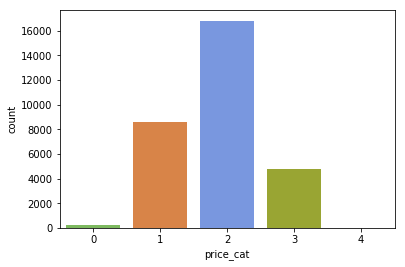

In [102]:
sns.countplot(x='price_cat', data=df, palette=pkmn_type_colors)

/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


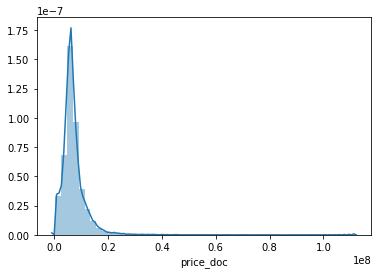

In [98]:
# Distribution Plot (a.k.a. Histogram)
sns.distplot(df.price_doc)

In [ ]:
for col in xfinal[:5]:
    print(col)
    sns.violinplot(x="price_cat", y=col, data=X_train[['price_cat',col]])

/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


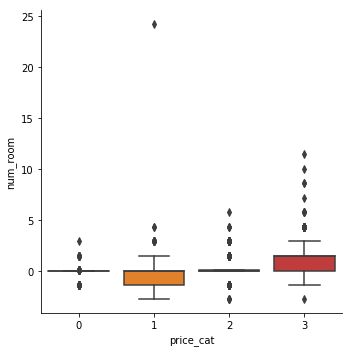

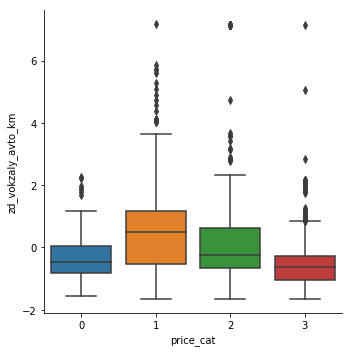

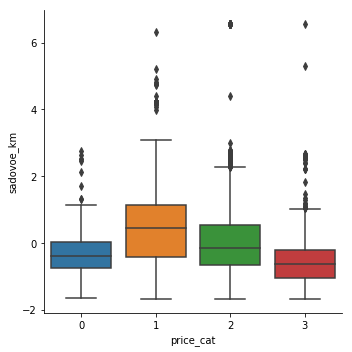

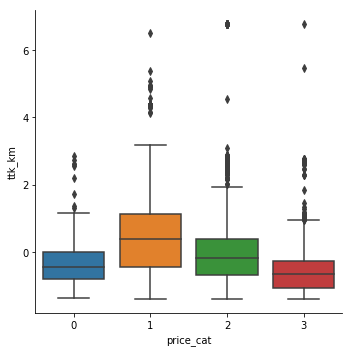

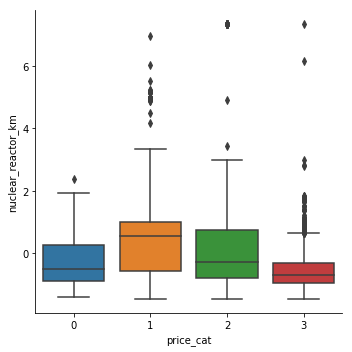

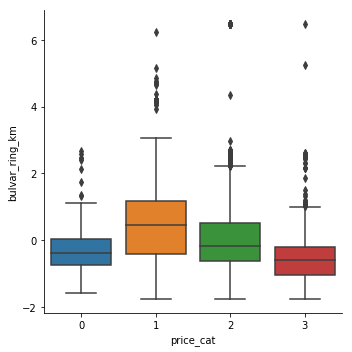

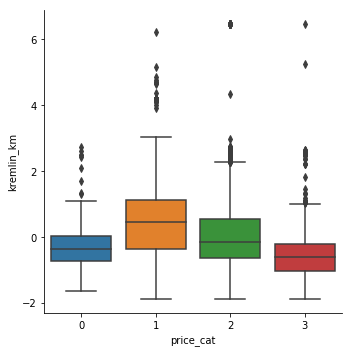

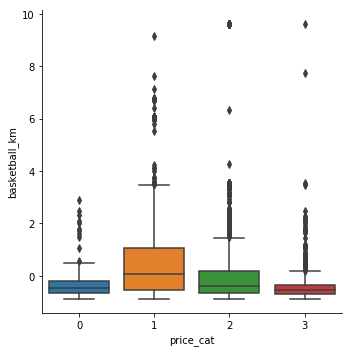

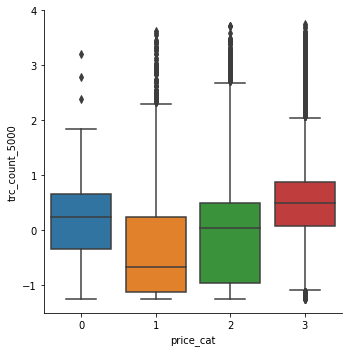

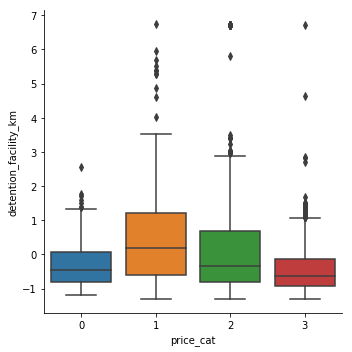

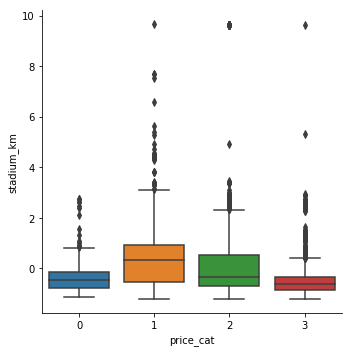

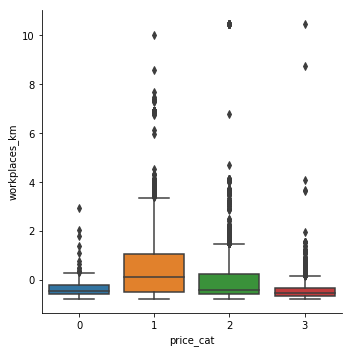

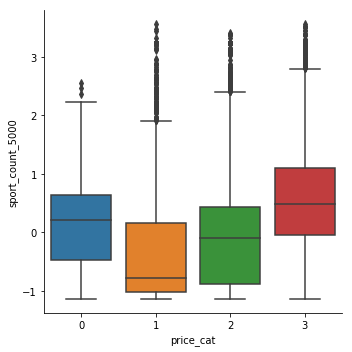

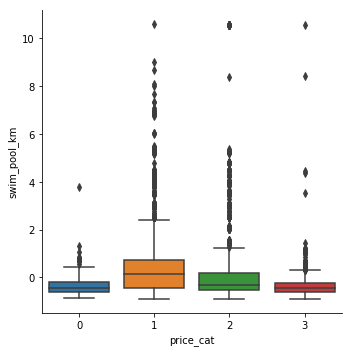

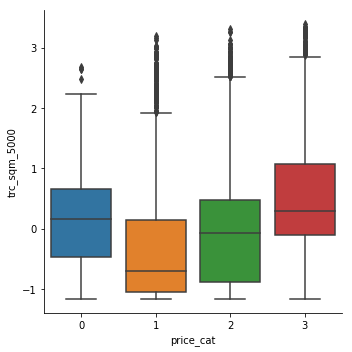

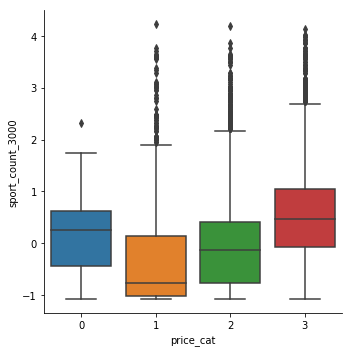

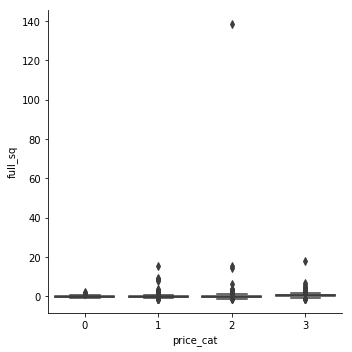

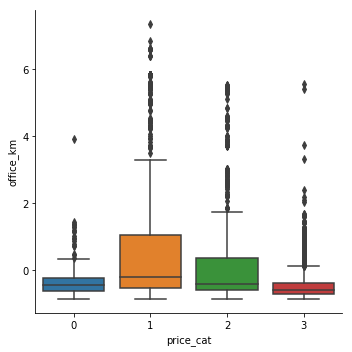

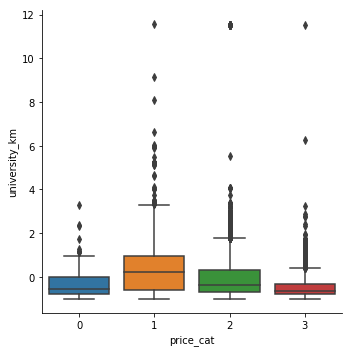

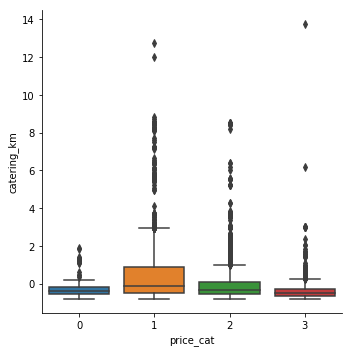

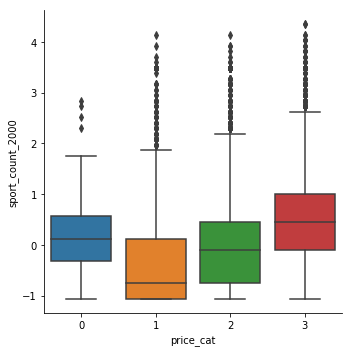

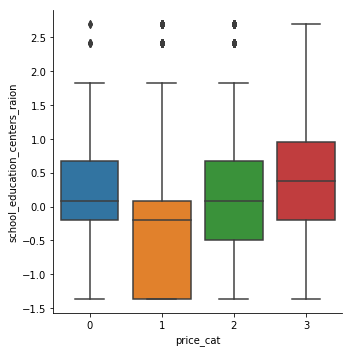

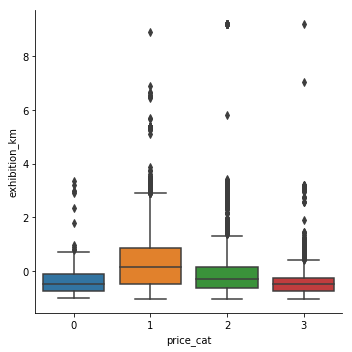

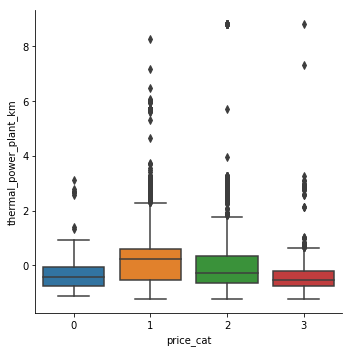

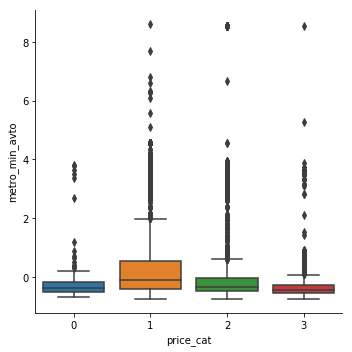

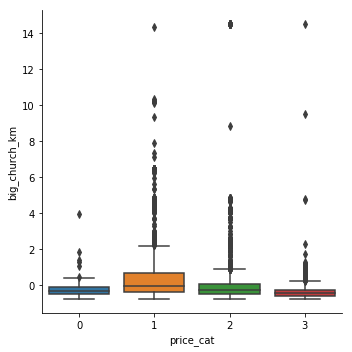

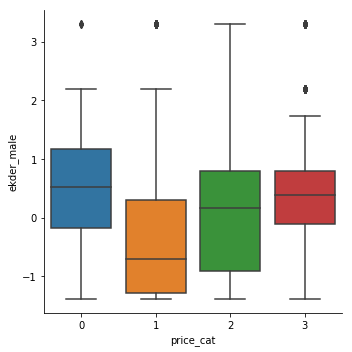

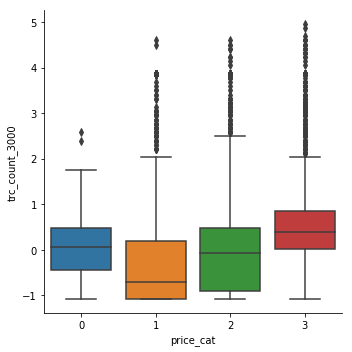

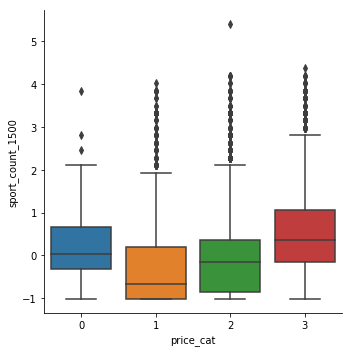

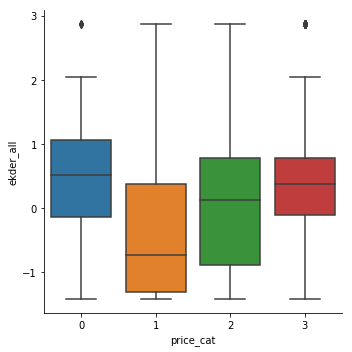

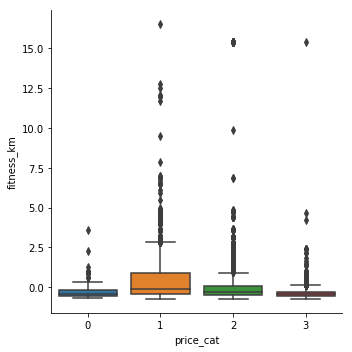

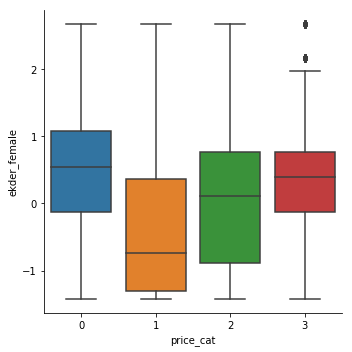

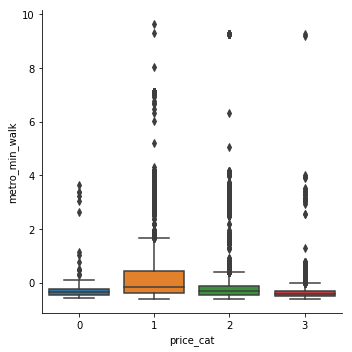

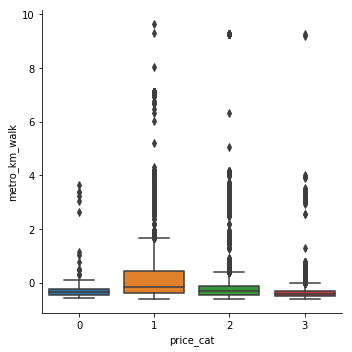

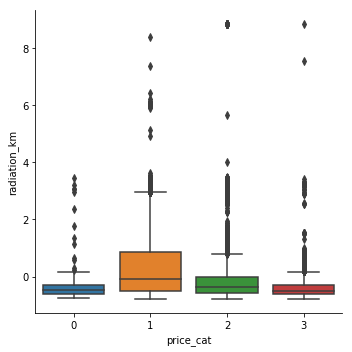

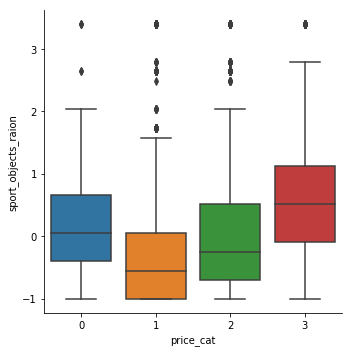

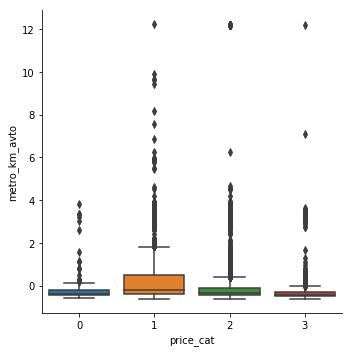

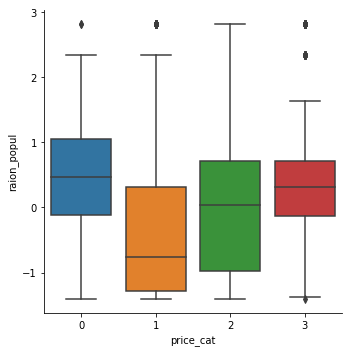

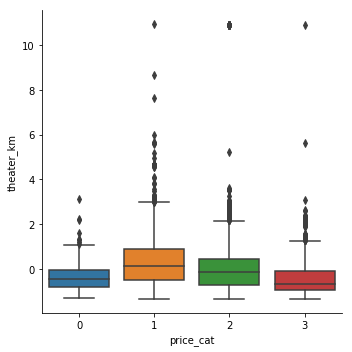

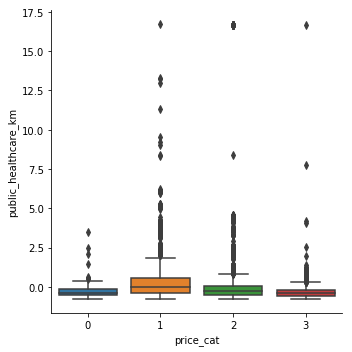

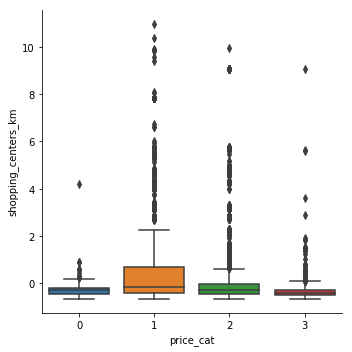

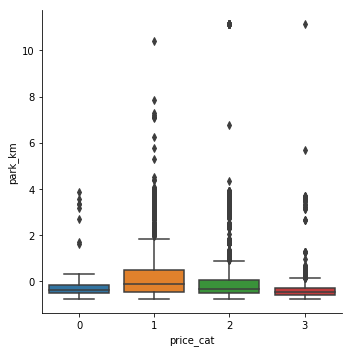

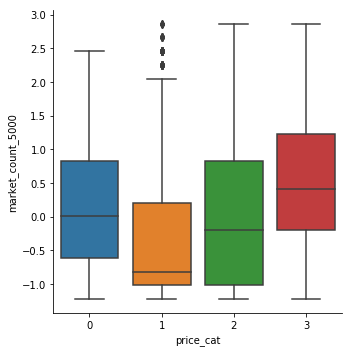

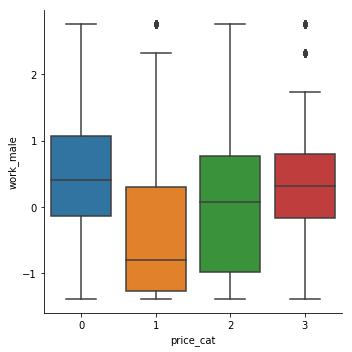

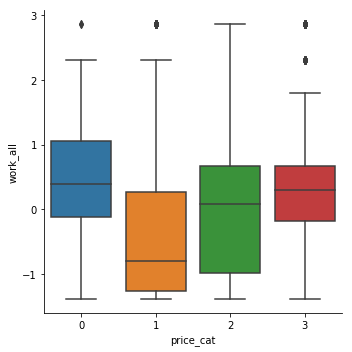

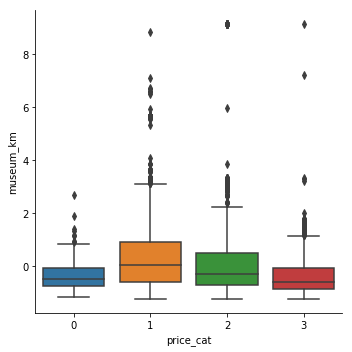

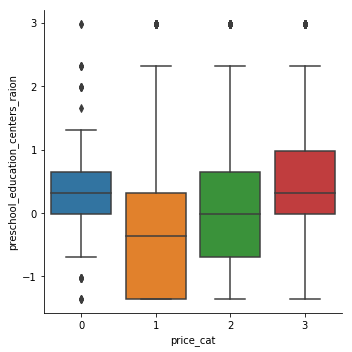

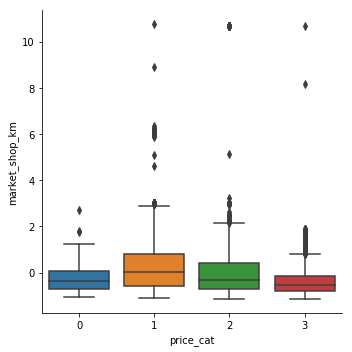

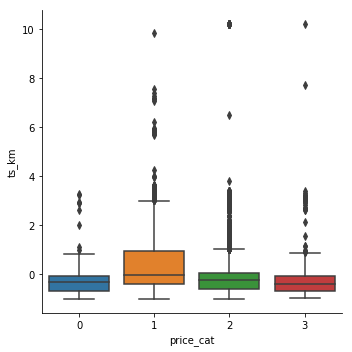

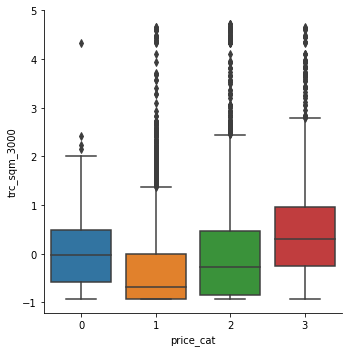

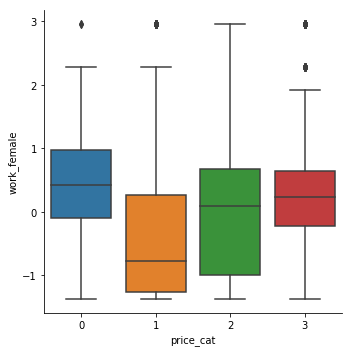

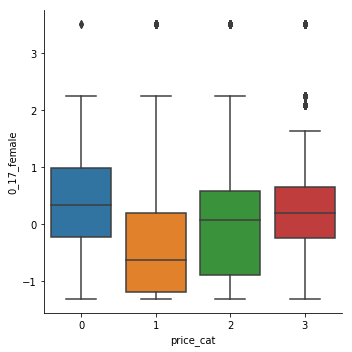

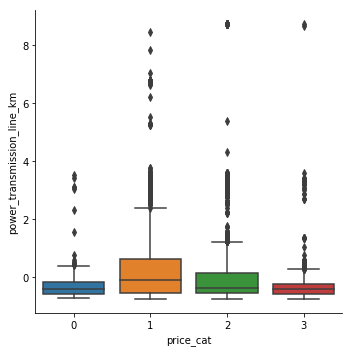

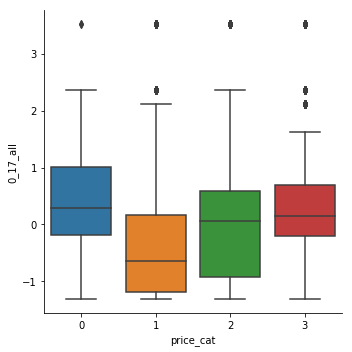

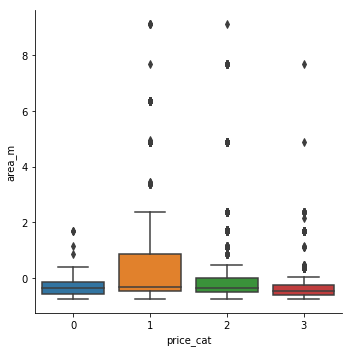

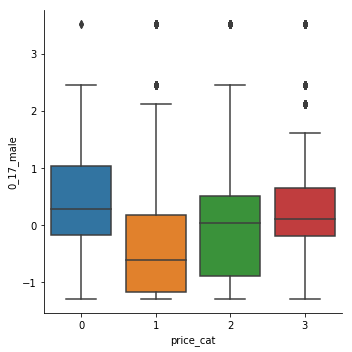

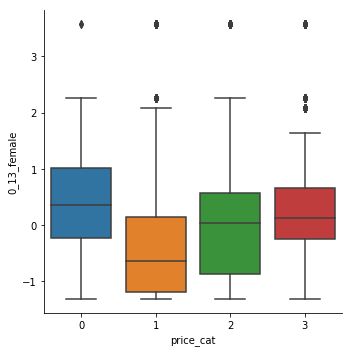

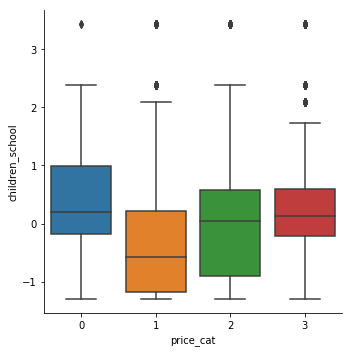

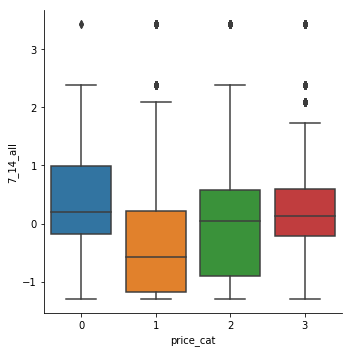

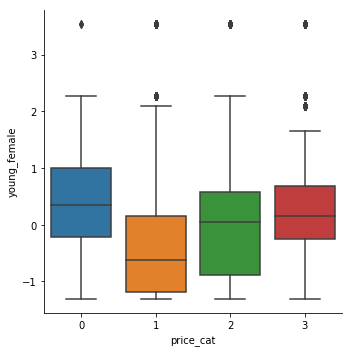

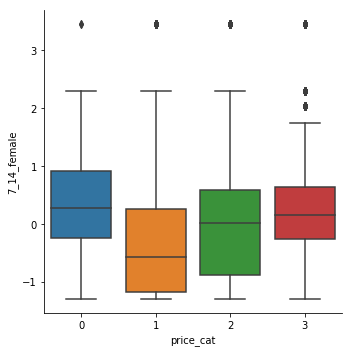

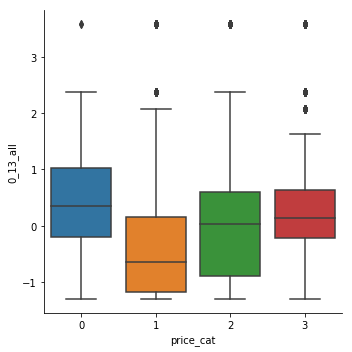

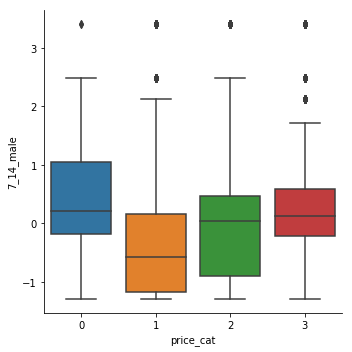

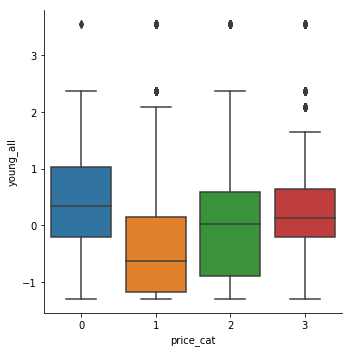

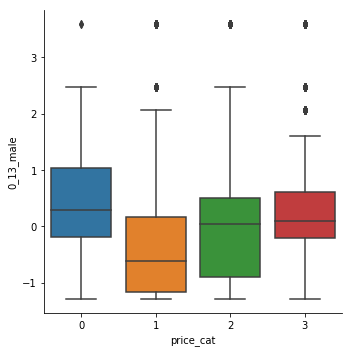

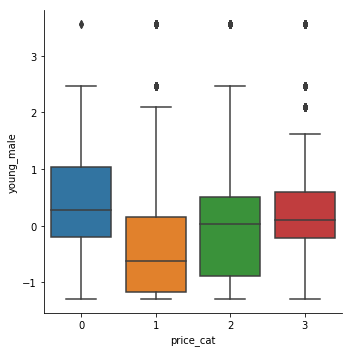

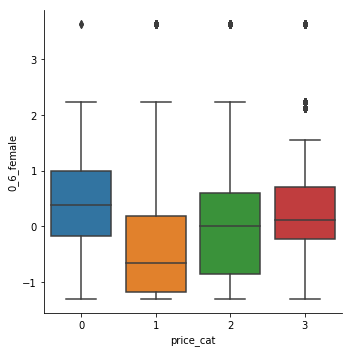

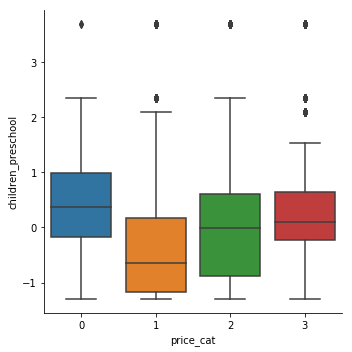

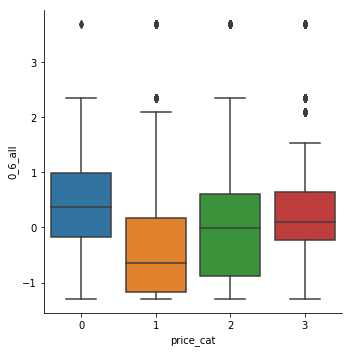

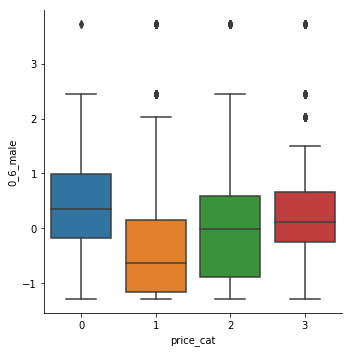

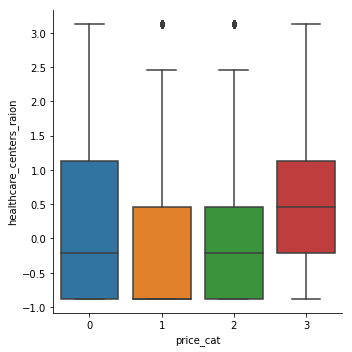

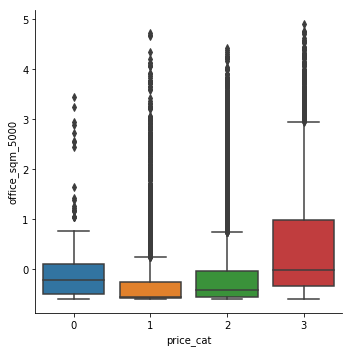

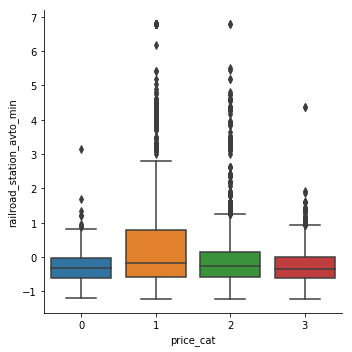

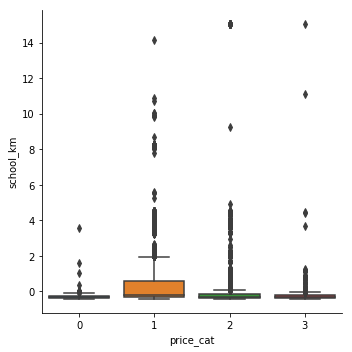

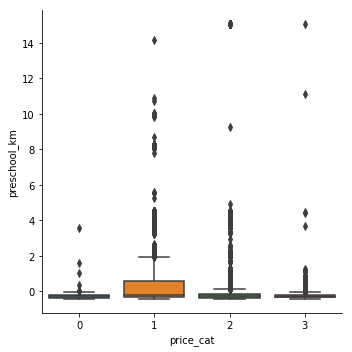

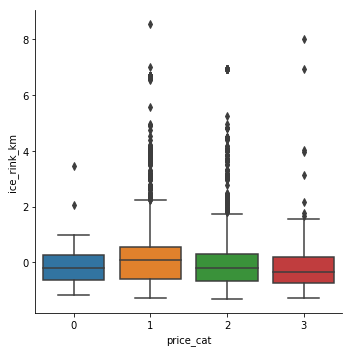

In [99]:
for col in xfinal:
    sns.catplot(x="price_cat", y=col, kind="box", data=X_train[['price_cat',col]])

2018-10-29 17:46:26.395624
2018-10-29 17:46:26.447056


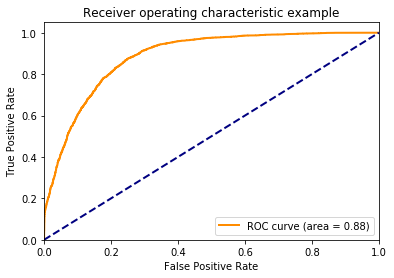

2018-10-29 17:47:23.181689


In [112]:
# Learn to predict each class against the other
print (dt.datetime.now())
n_classes = 4
classifier = OneVsRestClassifier(RandomForestClassifier(n_estimators=500, max_depth=10,random_state=0, n_jobs=2))
print (dt.datetime.now())
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

y_true = label_binarize(y_test, classes=[0, 1, 2, 3])

for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
print (dt.datetime.now())

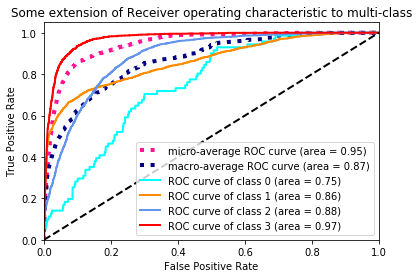

In [113]:
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()